# AMP筛选脚本

# 阶段 1：导入依赖与环境配置

在本研究的实验准备阶段，我们首先构建了稳定、可复现的运行环境，以支持后续的大规模蛋白序列生成与结构预测任务。具体而言，除了**常用的`np,pd,fair-esm`等**依赖我们基于 Python 环境安装并升级了以下核心依赖：

- **`transformers==4.33.3`**：用于加载和调用 HuggingFace 提供的蛋白语言模型，包括 Tranception 和 ESMFold；
- **`safetensors==0.4.2`**：用于加载安全高效的模型权重格式，避免传统 `.bin` 文件在大模型加载过程中的内存碎片问题；
- **`Biopython`**：用于蛋白序列的解析与生物信息处理，例如突变标签提取和 BLOSUM62 评分。

为确保依赖版本的正确性，代码中调用了 `print(transformers.__version__)` 和 `print(safetensors.__version__)` 进行版本验证。针对模型运行的硬件支持，进一步通过 `torch.version.cuda` 和 `torch.cuda.is_available()` 检查了本地环境中 CUDA 的可用性与 PyTorch 版本（目标为 2.0.0）。该检查确认了当前系统是否支持 GPU 加速，这对于后续执行结构预测模型（如 ESMFold 和 AlphaFold）至关重要，尤其在面对大批量高复杂度序列时，GPU 的存在可显著提升推理效率与任务完成速度。

本阶段的配置保证了模型加载、运行与推理的稳定性，是整个蛋白设计与评估流程的基础。通过该步骤的依赖确认与环境搭建，后续模型训练、序列生成、多模型打分与结构预测等任务得以在兼容、高效的计算环境中顺利开展。

In [1]:
!pip install fair-esm openpyxl scikit-learn pandas numpy torch xlrd datasets
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [openpyxl]3/4 [openpyxl]


In [2]:
!pip install --upgrade transformers==4.33.3
!pip install Biopython

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 KB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.5 MB/s eta 0:00:00:00:0100:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 74.9 MB/s eta 0:00:00:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.


In [3]:
import transformers
print(transformers.__version__)

/home/ma-user/anaconda3/envs/PyTorch-2.0.0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.33.3


In [4]:
!pip install --upgrade transformers==4.33.3
!pip install Biopython
!pip install --upgrade safetensors==0.4.2
import transformers
print(transformers.__version__)
import safetensors
print(safetensors.__version__)  # 应输出 0.4.2

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.5.3
    Uninstalling safetensors-0.5.3:
      Successfully uninstalled safetensors-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.7.0 requires safetensors>=0.4.3, but you have safetensors 0.4.2 which

In [5]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.__version__)  # 应输出 2.0.0

11.7
True
2.0.0+cu117


In [6]:
!pip show torch

Name: torch
Version: 2.0.0+cu117
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/ma-user/anaconda3/envs/PyTorch-2.0.0/lib/python3.9/site-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, torchaudio, torchvision, triton


**导入常用依赖库**

```python
import pandas as pd import numpy as np import torch import esm import os import random import re import warnings
```

此外，导入了 `sklearn.model_selection.train_test_split` 和 `sklearn.metrics.r2_score`，用于后续亮度预测器模型的训练集划分和性能评估。

------

**输入数据文件路径定义**

这部分定义了项目中关键的输入数据文件路径：

- `GFP_data.xlsx`：主数据集，包含蛋白序列与亮度等标签；
- `AAseqs of 4 GFP proteins.txt`：野生型序列（WT）信息，作为突变设计的参考基础；
- `Exclusion_List.csv`：排除列表，含不合法或不希望使用的序列（如实验失败或毒性序列），将在后续生成中剔除。

------

**超参数设置**

- `ESM_MODEL_NAME`：选择中等规模的预训练蛋白语言模型，兼顾预测精度与计算成本；
- `MAX_MUTATIONS`：最大突变位点数，符合竞赛规则；
- `N_CANDIDATES_TO_GENERATE`：每轮候选序列生成数量；
- `TOP_N_SELECT`：最终入选的候选序列数量（如用于 AlphaFold 验证或实验）。

------

**硬件环境检查与打印**

------

**全局随机种子设置（可复现性）**



In [15]:
import pandas as pd  # 处理表格数据（如 Excel、CSV）
import numpy as np   # 数学计算库
import torch         # PyTorch，主要用于模型加载与运行
import esm           # Facebook 的蛋白语言模型库 ESM（用于提取蛋白序列嵌入）
import os            # 操作文件路径
import random        # 设置随机种子
from sklearn.model_selection import train_test_split  # 训练集测试集划分
from sklearn.metrics import r2_score                  # 模型性能评估指标
import re           # 正则表达式，用于处理突变信息
import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息（不影响主逻辑）

# 常量定义
TRAIN_DATA_FILE = os.path.join('GFP_data.xlsx')
# 包含亮度、突变信息等训练数据的 Excel 文件
WT_SEQ_FILE = os.path.join('AAseqs of 4 GFP proteins.txt')
# 4 个 GFP 蛋白的氨基酸序列（wild-type 序列），后续将基于这些序列设计突变
EXCLUSION_FILE = os.path.join('Exclusion_List.csv')
# 不允许的序列清单，可能是失败序列、毒性序列等（用于过滤）


# --- 模型与生成参数 ---
ESM_MODEL_NAME = "esm2_t12_35M_UR50D" # 选择一个中等大小的ESM模型，平衡速度和性能
MAX_MUTATIONS = 6 # 比赛规则：最多6个突变
N_CANDIDATES_TO_GENERATE = 500 # 生成候选序列的数量（可调整）
TOP_N_SELECT = 10 # 最终选择的序列数量

# 检查是否有可用的 GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 设置随机种子以便结果可复现（可选）
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda




 # 阶段 2：数据加载与预处理
该阶段的目标是从多个数据源加载原始信息，并将其处理为可用于模型输入和突变设计的结构化格式，主要包括亮度标签、野生型序列、突变标签以及排除项。





## 2.1 加载训练数据集（GFP_data.xlsx）
首先通过 pandas 读取 GFP_data.xlsx 文件中的 'brightness' 工作表，作为训练数据来源。该表格包含多个 GFP 蛋白的突变序列、突变标签（如 aaMutations）、完整蛋白序列以及其对应的亮度实验结果（如 Brightness 或 log Brightness），为亮度预测器模型的训练提供了监督标签。



In [16]:
print("Loading training data...")
try:
    xsl = pd.ExcelFile(TRAIN_DATA_FILE,engine='openpyxl') # 假设亮度数据在名为 'brightness' 的 sheet
    gfp_df = xsl.parse('brightness')
    print(f"Loaded {len(gfp_df)} rows from {TRAIN_DATA_FILE}")
except FileNotFoundError:
    print(f"Error: Training data file not found at {TRAIN_DATA_FILE}")
    exit() # 如果文件不存在，可能需要停止执行

Loading training data...
Loaded 147950 rows from GFP_data.xlsx


## 2.2 读取野生型蛋白序列（WT_SEQ_FILE）
随后从 AAseqs of 4 GFP proteins.txt 文件中解析出 avGFP 的野生型序列。该文件采用类似 FASTA 的格式，使用 > 开头的 header 来标识序列名称，后面接氨基酸序列本体。程序通过关键字（如 “avGFP”）定位目标序列并提取其主序列，用于后续的突变生成参考。

In [17]:
print("Loading avGFP WT sequence...")
avGFP_WT_sequence = None
try:
    with open(WT_SEQ_FILE, 'r') as f:
        # 假设文件格式是 >Header \n Sequence \n >Header2...
        # 我们需要找到 avGFP 的序列
        header = ""
        seq_lines = []
        for line in f:
            if line.startswith('>'):
                # 如果找到了上一个序列，并且是avGFP，保存它
                if "avGFP" in header and seq_lines:
                    avGFP_WT_sequence = "".join(seq_lines).strip()
                    break # 找到后退出循环
                # 开始新的序列记录
                header = line.strip()
                seq_lines = []
            else:
                seq_lines.append(line.strip())
        # 处理文件最后一个序列的情况
        if avGFP_WT_sequence is None and "avGFP" in header and seq_lines:
             avGFP_WT_sequence = "".join(seq_lines).strip()

    if avGFP_WT_sequence:
        print(f"Found avGFP WT sequence (Length: {len(avGFP_WT_sequence)}).")
        print(avGFP_WT_sequence) #查看序列
    else:
        print("Error: avGFP WT sequence not found in", WT_SEQ_FILE)
        #没找到手动设置一个默认值或停止执行
        avGFP_WT_sequence = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK" 
        print("Using default WT sequence.")
        exit()

except FileNotFoundError:
    print(f"Error: WT sequence file not found at {WT_SEQ_FILE}")
    exit()

Loading avGFP WT sequence...
Found avGFP WT sequence (Length: 238).
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK


## 2.3 加载排除列表（Exclusion_List.csv）
程序还加载了一个名为 Exclusion_List.csv 的排除列表数据，用于过滤掉某些不合法或不推荐的序列。这些序列可能来源于实验失败、毒性反应等历史记录。通过后续的比对操作，程序会确保生成的候选序列不会与这些“黑名单”重合。

In [18]:
print("Loading exclusion list...")
try:
    exclusion_df = pd.read_csv(EXCLUSION_FILE)
    # 排除序列在名为 'sequences-not-submit' 的列中
    exclusion_sequences = set(exclusion_df['sequences-not-submit'].astype(str))
    print(f"Loaded {len(exclusion_sequences)} sequences into exclusion list.")
except FileNotFoundError:
    print(f"Error: Exclusion list file not found at {EXCLUSION_FILE}")
    exclusion_sequences = set() # 如果文件不存在，创建一个空集合
    print("Warning: Proceeding without an exclusion list.")
except KeyError:
    print(f"Error: Column 'sequences-not-submit' not found in {EXCLUSION_FILE}")
    exclusion_sequences = set()
    print("Warning: Proceeding without an exclusion list.")

Loading exclusion list...
Loaded 739 sequences into exclusion list.


## 2.4 预处理训练数据
#### 参数说明：

- `mutation_str`：突变描述字符串，例如 `"WT"` 或 `"A12B:C34D"`；
- `wt_sequence`：avGFP 的野生型氨基酸序列。

#### 逻辑说明：

1. 若为 `WT`（wild-type，野生型），直接返回原序列。
2. 否则，将突变字符串按 `:` 拆分为多个突变（支持多点突变）。
3. 用正则表达式匹配每个突变的格式，如 `G101A`（即第101位的G被换成了A）。
4. 验证突变位置是否合法，是否在序列长度范围内。
5. 检查突变位置的原始氨基酸是否与实际匹配（建议，但可跳过）。
6. 如果突变为 `*`（终止密码子），视为无效突变，返回 `None`。
7. 如果突变为 `.`，表示保持原氨基酸不变。
8. 将突变后的字符替换到序列中。
9. 最终返回突变后的完整序列字符串。

In [19]:
print("Preprocessing training data...")
# 筛选 avGFP 数据
avGFP_train_df = gfp_df[gfp_df['GFP type'] == 'avGFP'].copy()
print(f"Filtered down to {len(avGFP_train_df)} avGFP entries.")

# 定义函数：根据突变字符串生成完整序列
def generate_mutated_sequence(mutation_str, wt_sequence):
    """
    根据突变描述字符串和野生型序列生成突变后的完整序列。
    mutation_str: e.g., "WT", "G101A", "A12B:C34D"
    wt_sequence: 野生型氨基酸序列字符串
    """
    if not isinstance(mutation_str, str) or not wt_sequence:
        return None
    if mutation_str.strip().upper() == 'WT':
        return wt_sequence

    sequence = list(wt_sequence)
    mutations = mutation_str.split(':') # 支持多个突变，以冒号分隔
    valid_mutation_count = 0
    try:
        for mut in mutations:
            match = re.match(r'([A-Z])(\d+)([A-Z*.])$', mut.strip(), re.IGNORECASE) # 匹配 G101A, T203*, V163.
            if match:
                original_aa, pos, new_aa = match.groups()
                pos = int(pos)# 转换为 0-based index

                # 检查位置是否有效
                if pos < 0 or pos >= len(sequence):
                    # print(f"Warning: Invalid position {pos+1} in mutation '{mut}' for sequence length {len(sequence)}. Skipping mutation.")
                    continue # 跳过无效位置的突变

                # 检查原始氨基酸是否匹配
                if sequence[pos].upper() != original_aa.upper():
                    print(f"Warning: Original AA mismatch at position {pos+1} in mutation '{mut}'. Expected {sequence[pos]}, got {original_aa}. Applying mutation anyway.")
                    pass # 允许不匹配，但打印警告

                # 处理特殊字符
                if new_aa == '*': # 终止密码子 - 通常不希望出现在中间
                    # print(f"Warning: Stop codon '*' mutation '{mut}' encountered. Treating as deletion or invalid sequence for this tutorial.")
                    # 对于亮度预测，终止密码子通常导致无功能蛋白，返回None
                    return None 
                elif new_aa == '.': # 表示与原氨基酸相同 (无突变)
                    new_aa = sequence[pos] # 保持不变

                sequence[pos] = new_aa.upper()
                valid_mutation_count += 1
            else:
                print(f"Warning: Could not parse mutation '{mut}'. Skipping.")
                pass # 跳过无法解析的突变格式
        # 如果没有成功应用任何突变（可能是格式问题），返回None
        if valid_mutation_count == 0 and mutations:
            return None
        return "".join(sequence)
    except Exception as e:
        print(f"Error processing mutation string '{mutation_str}': {e}")
        return None # 返回 None 表示序列生成失败

# 应用函数生成序列
avGFP_train_df['full_sequence'] = avGFP_train_df['aaMutations'].apply(
    lambda x: generate_mutated_sequence(x, avGFP_WT_sequence)
)

# 清理数据：移除序列生成失败或亮度无效的行
original_len = len(avGFP_train_df)
avGFP_train_df.dropna(subset=['full_sequence', 'Brightness'], inplace=True)
# 确保亮度是数值类型
avGFP_train_df['Brightness'] = pd.to_numeric(avGFP_train_df['Brightness'], errors='coerce')
avGFP_train_df.dropna(subset=['Brightness'], inplace=True)

print(f"Removed {original_len - len(avGFP_train_df)} rows due to invalid sequences or brightness.")
print(f"Final training set size: {len(avGFP_train_df)}")

# 查看处理后的数据
print("\nSample of processed training data:")
print(avGFP_train_df[['aaMutations', 'Brightness', 'full_sequence']].head(10))
avGFP_train_df.to_excel('processed_training_data.xlsx', index=False) # 保存处理后的数据
print("Processed training data saved to 'processed_training_data.xlsx'.")

Preprocessing training data...
Filtered down to 54025 avGFP entries.
Removed 2310 rows due to invalid sequences or brightness.
Final training set size: 51715

Sample of processed training data:
                     aaMutations  Brightness  \
0                             WT    3.719212   
1                          A109D    1.301030   
2  A109D:N145D:I187V:M232T:L235P    1.301031   
3        A109D:Y142N:H147L:E221G    1.301189   
4                          A109G    3.708478   
5        A109G:K139M:R167C:L235P    3.582764   
6  A109G:K155E:F164S:L193Q:L194P    1.499573   
7                    A109G:K157R    3.659013   
8  A109G:K157R:I160V:I187V:T224S    3.573855   
9  A109P:K112R:G173S:L177P:S201G    1.301031   

                                       full_sequence  
0  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...  
1  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...  
2  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...  
3  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...  
4 

# 阶段3：Mutation Library构建策略

------

## 阶段 1：引导式小批量生成（高质量种子）

**与上一届选用位点枚举得到的library的优点**：

- 控制生成质量，避免全空间暴力枚举带来的大量“死序列”
- 强化已知高亮度区域的探索深度，利于模型迭代与多目标打分
- 适合结合你已有的亮度训练数据使用 VAE / Transformer 进行生成

### 细化点：

| 项目                           | 建议                                                         |
| ------------------------------ | ------------------------------------------------------------ |
| **VAE/Transformer 解码器采样** | 使用 `Top-k` 或 `nucleus sampling` 策略（p=0.9），避免低概率垃圾序列 |
| **突变控制**                   | 在采样输出中限制最多只变异 ≤6 个位点                         |
| **高频突变位点控制**           | 从亮度数据集以及文献参考中统计频率高的突变位点，例如 F64, S65, M153, T203 等优先设为候选位置 |
| **隐空间子采样（亮度引导）**   | 将训练集中亮度最高的序列映射到 latent space，进行“高亮区域附近”采样（引导生成更亮的候选） |
| **筛选机制**                   | 添加简单模型筛选器（如 MLP/Ridge），快速过滤极端无效序列（如带 stop codon、极端保守位点突变） |

###  输出目标：

- **5,000 ~ 50,000 条序列**：均为结构合理、突变点分布良好、分布接近训练集中高亮度区域

------

##  阶段 2：结构化扩展（百万级突变空间）

- 用结构信息 +进化启发约束搜索空间，比盲目组合更科学
- 可结合 MPNN、RFdiffusion、AlphaFold 等工具构建“热稳定+折叠可行”的序列变异空间

###  细化点：

| 策略                                      | 建议                                                         |
| ----------------------------------------- | ------------------------------------------------------------ |
| **多点突变扩展**                          | 对种子序列进行局部扩展，每次突变 1~2 个新位点（从候选位点集中选） |
| **结构启发**                              | 利用 AlphaFold pLDDT 分布或结构热核分析，避开核心β桶区域、保守氢键骨架 |
| **遗传算法 / CbAS / Simulated Annealing** |                                                              |

- 可对亮度预测模型建立适应度函数（fitness）<br>
- 结合变异概率控制多样性/稳定性之间平衡
   | **RFdiffusion 指导结构一致性** | 用 avGFP 的 backbone（或 AlphaFold预测结构）作为参考，生成结构一致的突变体 |
   | **热稳定性预测模块** | 加入 ΔΔG 预测（FoldX / DeepDDG）或温度诱导变异打分（如 FireProt）做双向过滤 |

### 输出目标：

- **1M~100M 条序列**（非冗余、结构合理、未出现在训练集中的变体）
- 可根据预测亮度/热稳打分排序选 top-k

#### 3.1.1 基于突变频率筛选 top-60 位点

为了限制变异空间并提升模型学习效率，我们首先对训练集中已有的蛋白突变信息进行统计，选取突变频率最高的 60 个氨基酸位点作为候选突变位点集合。这一策略具有如下意义：

- **降维作用**：在全长 200 多个残基的 GFP 序列中，任意突变组合构成的空间极其庞大。通过聚焦频繁突变区域，有效减少搜索空间维度，使后续生成模型聚焦于功能相关区域。
- **生物学动因**：突变频率高的位点往往是亮度改造过程中的“热点位点”，可能已在历史实验中被多次验证对亮度有显著影响，因此具有更高的信息密度。
- **稳定建模基础**：由于这些位点在训练集中覆盖度高，有助于模型稳定学习突变-功能之间的关系，避免稀疏数据带来的建模困难。

具体方法如下：

- 对 `aaMutations` 字段中的每条突变标签（如 `"G101A:T203F"`）进行正则解析，提取所有突变发生的位置编号（如 101, 203）；
- 累加所有训练集中突变位点的出现频率，形成位点频数分布；
- 对分布排序，取频率最高的前 60 个位点，作为后续突变控制与编码输入的索引模板；
- 该集合也将作为后续构建 mutation matrix 的列索引，确保候选序列的突变受控且可比较。

该 top-60 位点集合最终以 `top_positions.csv` 保存，用于后续模型训练和生成阶段调用。### 3.1.1 根据频率进行筛选top60点位

In [11]:
from collections import Counter
# 配置
INPUT_LEN = 60
AA_TOKENS = list("ACDEFGHIKLMNPQRSTVWY*.")
AA_TO_IDX = {aa: i+1 for i, aa in enumerate(AA_TOKENS)}  # 0 for no mutation

# 加载训练数据
df = pd.read_excel("processed_training_data.xlsx",engine='openpyxl')

# 提取高频突变位点
def extract_positions(mutation_str):
    if mutation_str.strip().upper() == "WT":
        return []
    positions = []
    for mut in mutation_str.split(":"):
        match = re.match(r"[A-Z](\d+)[A-Z*\.]", mut.strip())
        if match:
            positions.append(int(match.group(1))+1)
    return positions

mutation_pos_counter = Counter()
for muts in df['aaMutations']:
    mutation_pos_counter.update(extract_positions(muts))
top_positions = [pos for pos, _ in mutation_pos_counter.most_common(INPUT_LEN)]

# 构建突变编码矩阵
mutation_matrix = np.zeros((len(df), INPUT_LEN), dtype=int)
for i, muts in enumerate(df['aaMutations']):
    if muts.strip().upper() == "WT":
        continue
    for mut in muts.split(":"):
        match = re.match(r"([A-Z])(\d+)([A-Z*\.])", mut.strip())
        if match:
            _, pos, to_aa = match.groups()
            pos = int(pos)
            if pos in top_positions:
                col_idx = top_positions.index(pos)
                mutation_matrix[i, col_idx] = AA_TO_IDX.get(to_aa.upper(), 0)

# 保存突变编码矩阵
np.save("mutation_matrix.npy", mutation_matrix)
mut_matrix_index=pd.DataFrame(top_positions, columns=["Position"])
mut_matrix_index.to_csv("top_positions.csv", index=False)
print("mut_encoded matrix and index is saved")
print(mut_matrix_index)
print(mutation_matrix)
print(top_positions[13])

mut_encoded matrix and index is saved
    Position
0        164
1        229
2        121
3        128
4         99
5        144
6        233
7        198
8        214
9        153
10       159
11       113
12       158
13         8
14       171
15       170
16       165
17       149
18       156
19        79
20       107
21       146
22       130
23       166
24       223
25       105
26        46
27        23
28        84
29       161
30       135
31        71
32       167
33       185
34        47
35       209
36        52
37       101
38       100
39       212
40       140
41        88
42       126
43       131
44       136
45       162
46        78
47         3
48        26
49        41
50       218
51       123
52        45
53        68
54       188
55       114
56        98
57       176
58        83
59        62
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
8


### 3.1.2 结合 PDB 结构信息识别功能相关位点

为提高突变策略的生物学合理性与功能导向性，我们不仅从突变频率出发选取高频突变位点，还进一步结合 avGFP 的三维结构信息，识别靠近荧光核心区域（chromophore）以及形成结构核心的氨基酸残基。这一策略基于如下考虑：

- **荧光团周围残基对亮度影响显著**，直接参与电子跃迁环境的形成；
- **空间接近性决定了突变对结构稳定性或功能性的干扰程度**；
- **利用结构邻接矩阵可支持后续图神经网络、接触映射或空间约束设计**。

------

#### 加载 avGFP 的结构模型（PDB 文件）

使用 Bio.PDB 模块载入 AlphaFold2 模型预测的 avGFP 结构（`AF-P42212-F1-model_v4.pdb`）。从该文件中提取第一个模型与链（默认单链），遍历所有残基并提取主链 α-碳（CA）原子的坐标。

------

#### 构建结构信息表

对每一个有效残基记录：

- 残基编号 `Residue_ID`
- 三字母氨基酸名称（可选）
- 主链 CA 原子的三维坐标

构建为 `df_structure`，用于后续几何计算。

------

#### 计算残基与荧光团之间的空间距离

- 选取荧光团关键残基编号（如 Tyr64, Gly65, Ser66）；
- 提取这三个残基的 CA 坐标，并计算其质心位置，作为 **chromophore center**；
- 对所有其他残基，计算其与荧光团中心的欧几里得距离；
- 若该距离小于 10 Å，则认为“靠近荧光团”。

该信息存入字段 `Dist_to_Chromophore` 和 `Nearby_Chromophore`，用于标注与功能核心的空间关系。

------

#### 构建残基邻接矩阵

- 提取所有残基的 CA 坐标；
- 计算任意两个残基之间的欧几里得距离；
- 若距离小于 8.0 Å，则认为两者在三维结构中“相邻”；
- 构建 0-1 的邻接矩阵 `adj_matrix`，表示残基之间的直接接触关系。

这一邻接矩阵将在后续结构引导的突变策略（如限制仅突变结构邻近区）或结构感知模型（如 GNN）中发挥作用。

------

#### 数据保存

- `df_structure` 保存为 Excel 文件，记录每个残基的编号、坐标、距离及是否靠近荧光团；
- `distance_matrix.npy` 和 `adjacency_matrix.npy` 作为结构参考图保存，用于后续建模。### 3.1.2 PDB结构点位筛选

In [12]:
!pip install biopython

from Bio import PDB
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# --- 1. 载入 PDB 文件 ---
pdb_file = "AF-P42212-F1-model_v4.pdb"

# --- 2. 读取结构 ---
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("avGFP", pdb_file)
model = structure[0]
chain = list(model.get_chains())[0]

# --- 3. 提取残基信息 ---
residue_info = []
ca_coords = []
res_indices = []

for residue in chain:
    res_id = residue.get_id()
    if res_id[0] == " ":  # 排除水分子/杂原子
        resseq = res_id[1]
        resname = residue.get_resname()
        ca = residue["CA"] if "CA" in residue else None
        coord = ca.coord if ca is not None else None  # ✅ 显式判断
        residue_info.append((resseq, resname, coord))
        if coord is not None:
            ca_coords.append(coord)
            res_indices.append(resseq)

# --- 4. 构建 DataFrame ---
df_structure = pd.DataFrame(residue_info, columns=["Residue_ID", "Residue_Name", "CA_Coord"])

# --- 修复点 1：确保 Residue_ID 为整数 ---
df_structure["Residue_ID"] = pd.to_numeric(df_structure["Residue_ID"], errors="coerce")

# --- 修复点 2：正确提取荧光团坐标 ---
chromophore_residues = [64, 65, 66]
chromo_rows = df_structure[df_structure["Residue_ID"].isin(chromophore_residues)]

# 只保留有有效坐标的行
chromophore_coords = [np.array(coord) for coord in chromo_rows["CA_Coord"] if isinstance(coord, np.ndarray) and coord.shape == (3,)]

# --- 5. 计算荧光团中心 ---
chromophore_center = np.mean(chromophore_coords, axis=0) if len(chromophore_coords) == 3 else None

# --- 修复点 3：计算距离函数 robust 化 ---
def compute_distance(coord):
    if isinstance(coord, str):  # 有些 DataFrame 会存成字符串
        coord = np.fromstring(coord.strip("[]"), sep=" ")
    if chromophore_center is None or coord is None or len(coord) != 3:
        return np.nan
    return np.linalg.norm(coord - chromophore_center)

# --- 6. 应用距离计算 ---
df_structure["Dist_to_Chromophore"] = df_structure["CA_Coord"].apply(compute_distance)

# --- 7. 标注是否靠近荧光团（<10 Å） ---
df_structure["Nearby_Chromophore"] = df_structure["Dist_to_Chromophore"].apply(
    lambda d: "Yes" if pd.notna(d) and d < 10 else "No"
)

# --- 8. 生成邻接矩阵 ---
ca_array = np.array(ca_coords)
distance_matrix = cdist(ca_array, ca_array)  # 欧几里得距离
threshold = 8.0
adj_matrix = (distance_matrix < threshold).astype(int)

# --- 9. 保存结构信息和邻接矩阵 ---
df_structure.to_excel("GFP_PDB_structure_enhanced.xlsx", index=False)
np.save("GFP_CA_distance_matrix.npy", distance_matrix)
np.save("GFP_CA_adjacency_matrix.npy", adj_matrix)

# --- 10. 打印摘要 ---
print(df_structure.head(50))
print("\n邻接矩阵维度:", adj_matrix.shape)


Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.
    Residue_ID Residue_Name                   CA_Coord  Dist_to_Chromophore  \
0            1          MET    [9.345, 3.276, -20.995]            23.483324   
1            2          SER    [9.859, 6.183, -18.551]            22.154364   
2            3          LYS   [13.126, 6.773, -16.595]            23.009256   
3            4          GLY   [11.065, 6.289, -13.396]            19.327999   
4            5          GLU    [10.499, 2.585, -14.37]            19.062248   
5            6          GLU   [14.205, 1.858, -13.541]            21.406456   
6            7          LEU     [13.33, 2.541, -9.837]            18.751091   
7            8          PHE   [10.872, -0.455, -9.823]            16.751165   
8            9          THR  [13.057, -3.255, -11.346]            19.922075   
9    

## 3.1.3 DPSS：近似结构分析筛选突变位点

该策略不依赖昂贵的全原子能量计算或表面积算法，而是利用结构邻接矩阵和荧光团距离近似评估残基的**可突变性（mutation eligibility）**。其设计逻辑包括：

------

### 获取基础结构数据

- 从先前保存的结构表格 `GFP_PDB_structure_enhanced.xlsx` 中加载所有残基的三维坐标、距离荧光团中心等；
- 同时加载残基之间的邻接矩阵 `adj_matrix` 和欧几里得距离矩阵 `distance_matrix`，这两者用于近似估计每个残基的结构环境与暴露度。

------

### 计算每个残基的邻接数（degree）

- 每个残基的邻接数即为它与多少其他残基“相邻”（距离 < 8 Å）；
- 数值越大，表示该残基埋藏在内部、结构紧密；
- 数值越小，则可能位于表面或缺乏结构约束。

该信息存入字段 `Contact_Degree`。

------

### 判断是否“暴露”（Approx_Exposure）

- 设置经验阈值：`Contact_Degree <= 6` 即判定为暴露（Exposed）；
- 否则判定为埋藏（Buried）；
- 该标准为经验规则，尽管粗略但在无溶剂可接触面积数据时是合理替代。

------

### 结合荧光团距离进一步过滤

- 仅考虑 `Nearby_Chromophore == "No"` 的位点（即距离荧光团超过 10 Å）；
- 避免突变影响荧光活性中心区域，保障功能不被破坏；
- 联合判断是否暴露与远离功能核心，两者均满足才标记为 `Mutation_Eligible = True`。

------

### 输出推荐突变位点清单

最终筛选出所有满足条件的突变位点，排序策略为：

1. **优先远离荧光团（Dist_to_Chromophore 高）**
2. **优先低接触度（Contact_Degree 小）**

即优先推荐**最暴露且最远离功能核心的表面残基**，可认为它们既“安全”，又“对整体结构和功能干扰最小”，适合用于采样更多样化的突变组合。

结果保存为 Excel 文件 `"推荐突变位点（近似结构分析）.xlsx"`，用于 VAE 突变位点选择控制。


In [13]:
# 载入数据
import numpy as np
import pandas as pd

# 结构信息 + 邻接矩阵 + 距离矩阵
df_structure = pd.read_excel("GFP_PDB_structure_enhanced.xlsx",engine='openpyxl')
adj_matrix = np.load("GFP_CA_adjacency_matrix.npy")
distance_matrix = np.load("GFP_CA_distance_matrix.npy")

# 每个残基的连接数（degree）
degree = adj_matrix.sum(axis=1)
df_structure["Contact_Degree"] = degree

# 近似暴露度判断：连接数小于等于6视为暴露
df_structure["Approx_Exposure"] = df_structure["Contact_Degree"].apply(
    lambda x: "Exposed" if x <= 6 else "Buried"
)

# 综合打分策略：仅保留远离chromophore + 暴露位点
df_structure["Mutation_Eligible"] = df_structure.apply(
    lambda row: row["Nearby_Chromophore"] == "No" and row["Approx_Exposure"] == "Exposed",
    axis=1
)

# 提取推荐突变位点
eligible_sites = df_structure[df_structure["Mutation_Eligible"] == True][
    ["Residue_ID", "Residue_Name", "Dist_to_Chromophore", "Contact_Degree"]
].sort_values(by=["Dist_to_Chromophore", "Contact_Degree"], ascending=[False, True])
eligible_sites.to_excel("推荐突变位点（近似结构分析）.xlsx", index=False)


## 3.1.4 多信息源整合突变位点筛选与AvoidRegion排查

此方法集成了三类突变位点来源：

| 来源类别         | 说明                                                      |
| ---------------- | --------------------------------------------------------- |
| **频率统计**     | 来自训练集中突变频次最高的位点（数据驱动）                |
| **结构启发**     | 靠近蛋白质表面且远离荧光团的暴露残基（结构生物学启发）    |
| **文献经典位点** | 来自公开文献中已知对 GFP 功能有调控作用的位点（领域知识） |

### 残基标注：来源标识与区域排除

在结构残基表中为每一个 Residue_ID 添加三列布尔字段：

- `From_Literature`: 是否来源于文献；
- `From_Frequency`: 是否为突变高频位点；
- `From_Exposure`: 是否为暴露远离功能区的残基。

同时添加排除标记 `Avoid_Region`：例如 chromophore（荧光团核心）残基（65–67）将被打上负面标签，避免进入突变区域。
背景：

- S65、Y66、G67 是 GFP 荧光团的核心，突变它们：
  - 很容易破坏发光结构；
  - 失去功能或荧光消失；
  - 非常“危险”，除非有特别目的（如红移或蓝移发光谱）。

#### 所以：

要避免在这些高度关键区域“乱动”，除非你做的是染色体调节或已知工程突变（如 S65T 是 sfGFP 的经典突变）。

------

###  多因素综合打分机制

定义如下线性加权策略：

```
得分 = 1.5 × 文献支持 + 1.0 × 频率支持 + 1.5 × 暴露结构支持
```

- 文献和结构依据加权更高，体现“可信生物学指导”；
- 频率维度作为数据驱动支持，用于提升建模覆盖面；
- 被标记为 `Avoid_Region` 的残基直接赋值为 -1，强行排除。

该打分策略简单、可解释，能够在有限空间内聚焦那些“既被使用频繁、又安全且潜在有效”的位点。

最终以这些来源为特征，构建简单加权评分体系，输出 Top-K 位点。

In [2]:
# 整合所有突变信息来源，构建 Top-20 位点选择完整流程代码
import pandas as pd
import numpy as np
import re

# 加载输入文件
df_struct = pd.read_excel("GFP_PDB_structure_enhanced.xlsx",engine='openpyxl')
df_exposure = pd.read_excel("推荐突变位点（近似结构分析）.xlsx",engine='openpyxl')
df_lit = pd.read_csv("GFP_经典突变位点表.csv")
df_freq = pd.read_csv("top_positions.csv")

# 处理文献位点（如 F64）提取编号
def extract_position(val):
    match = re.search(r'(\d+)', str(val))
    return int(match.group(1)) if match else None
df_lit["Residue_ID"] = df_lit["位点"].apply(extract_position)

# 提取残基编号
lit_positions = df_lit["Residue_ID"].dropna().astype(int).tolist()
freq_positions = df_freq["Position"].tolist()
exposure_positions = df_exposure["Residue_ID"].tolist()

# 标记信息来源
df_struct["From_Literature"] = df_struct["Residue_ID"].apply(lambda x: int(x) in lit_positions)
df_struct["From_Frequency"] = df_struct["Residue_ID"].apply(lambda x: int(x) in freq_positions)
df_struct["From_Exposure"] = df_struct["Residue_ID"].apply(lambda x: int(x) in exposure_positions)

# 排除 chromophore 核心
df_struct["Avoid_Region"] = df_struct["Residue_ID"].apply(lambda x: x in [65, 66, 67])

# 打分函数
def score(row):
    if row["Avoid_Region"]:
        return -1
    return 1.5 * row["From_Literature"] + 1.0 * row["From_Frequency"] + 1.5 * row["From_Exposure"]

# 计算得分并排序
df_struct["Mutation_Score"] = df_struct.apply(score, axis=1)
top20_mutation_sites = df_struct.sort_values(by="Mutation_Score", ascending=False)
top20_mutation_sites = top20_mutation_sites[top20_mutation_sites["Mutation_Score"] > 0].head(20)

# 保存输出
output_path = "Top20_Mutation_Sites.csv"
top20_mutation_sites.to_csv(output_path, index=False)
print('Top20_Mutation_Sites.csv is saved')
print(top20_mutation_sites)

FileNotFoundError: [Errno 2] No such file or directory: 'GFP_PDB_structure_enhanced.xlsx'

## 表格列含义解释

| 列名                    | 含义                                       | 解释                                                         |
| ----------------------- | ------------------------------------------ | ------------------------------------------------------------ |
| **Residue_ID**          | 残基编号                                   | GFP 蛋白中该氨基酸的序号，对应 `avGFP` 的标准编号            |
| **Residue_Name**        | 三字母残基名称                             | 例如：`TYR`, `GLN`, `VAL`，即 Tyr, Gln, Val 等               |
| **CA_Coord**            | α-碳坐标                                   | 残基的三维空间坐标（可用于结构绘图或建模）                   |
| **Dist_to_Chromophore** | 距离 chromophore 的空间距离                | 从当前残基到 chromophore 中心（S65-Y66-G67）的欧几里得距离，单位 Å |
| **Nearby_Chromophore**  | 是否靠近 chromophore（<10Å）               | Yes/No 标记；用于避免核心光团周围不宜突变的位点              |
| **From_Literature**     | 来自文献支持                               | True/False：是否被 sfGFP/EGFP 等文献确认为重要突变位点       |
| **From_Frequency**      | 来自训练数据统计                           | True/False：是否在 `GFP_data.xlsx` 中高频出现且关联高亮度    |
| **From_Exposure**       | 来自近似结构暴露分析                       | True/False：是否是暴露残基（邻接数低），适合突变             |
| **Avoid_Region**        | 是否是 chromophore 核心区域（S65-Y66-Y67） | True 表示禁止突变，已排除                                    |
| **Mutation_Score**      | 综合打分                                   | 评分规则如下                                                |



------


## 阶段 3.2：基于多策略的突变残基候选推荐

### 目标

为每个已确定的突变位点，推荐一组**可能保留蛋白功能、结构更合理的突变残基集合**，用于构建最终的突变组合（Mutation Library）并输入到生成模型（如 VAE）或筛选系统。

In [15]:
import pandas as pd

# 读取经典突变位点参考表
classic_mutation_path = "GFP_经典突变位点表.csv"
classic_mut_df = pd.read_csv(classic_mutation_path)

# 查看数据结构
classic_mut_df.head(30)


,位点,野生型残基,经典突变,功能类别,功能说明,文献来源
0,F64,Phe,F64L,折叠 & 热稳增强,改善37°C表达、稳定性更高,"Cormack et al., 1996; Heim et al., 1995"
1,S65,Ser,S65T,亮度提升,激发波长从395 → 488nm，量子产率提升,"Heim et al., 1995; Tsien, 1998"
2,Y66,Tyr,Y66H/F/W,色调调节,改变荧光团性质，调节颜色（蓝光/红移）,"Ormö et al., 1996; Tsien, 1998"
3,T203,Thr,T203Y/F,发射峰红移 & 亮度增强,与荧光团 π-π stacking，提高亮度,"Zhang et al., 2006; Tsien, 1998"
4,M153,Met,M153T,折叠 & 热稳增强,Superfolder GFP 中的核心突变,"Pédelacq et al., 2006"
5,V163,Val,V163A,热稳定性提升,疏水核区域，小残基更利于折叠,"Pédelacq et al., 2006"
6,A206,Ala,A206K,抑制二聚化,阻止 GFP 在高浓度下形成二聚体,"Zacharias et al., 2002"
7,Y145,Tyr,Y145F,结构稳定性,内部氢键优化，提高桶结构稳定性,"Jung et al., 2005"
8,N149,Asn,N149K,可溶性增强,表面极性变化，改善表达,"Shaner et al., 2004"
9,S30,Ser,S30R,热稳增强,桶口桥联，防止展开,"Pédelacq et al., 2006"


In [13]:
# 加载 Top20 位点信息
top20_path = "Top20_Mutation_Sites.csv"
top20_df = pd.read_csv(top20_path)

# 建立突变位点到候选残基的映射
mutation_candidates = {}

# 建立经典突变位点映射表（便于查找）
classic_mut_map = classic_mut_df.groupby("位点")["经典突变"].apply(list).to_dict()
classic_wt_map = classic_mut_df.groupby("位点")["野生型残基"].first().to_dict()

for _, row in top20_df.iterrows():
    pos = int(row["Residue_ID"])
    wt = row["Residue_Name"]
    candidates = set()
    candidates.add(wt)  # 保留野生型残基

    # 如果该位点出现在经典突变表中
    if pos in classic_mut_map:
        for mut in classic_mut_map[pos]:
            if len(mut) >= 3 and mut[:len(str(pos))*(-1)] == wt:
                alt = mut[len(wt):-len(str(pos))]
            else:
                alt = mut[len(wt):-len(str(pos))] if mut.startswith(wt) else mut[-1]
            if alt.isalpha() and len(alt) == 1:
                candidates.add(alt)

    mutation_candidates[pos] = sorted(list(candidates))

mutation_candidates


{149: ['ASN'],
 153: ['MET'],
 214: ['LYS'],
 212: ['ASN'],
 68: ['VAL'],
 64: ['PHE'],
 222: ['GLU'],
 30: ['SER'],
 145: ['TYR'],
 206: ['ALA'],
 203: ['THR'],
 163: ['VAL'],
 130: ['PHE'],
 128: ['ILE'],
 136: ['ILE'],
 131: ['LYS'],
 135: ['ASN'],
 121: ['ASN'],
 140: ['LYS'],
 126: ['LYS']}

### 3.2.1 BLOSUM62 相似性筛选

#### 方法概述

BLOSUM62 是基于保守性统计构建的替换矩阵，得分高表示某个氨基酸替换在自然进化中较为常见，因此保守性高、破坏性小。

#### 实现步骤：

- 对于每个位点，取 WT 残基（如 F64）；
- 在 BLOSUM62 中寻找对 WT 残基打分 ≥ 1 的残基，认为它们在演化上相似；
- 最终形成：`{Residue_ID: [WT, AA1, AA2, ..., AAk]}` 的突变残基列表；
- 输出为 `"候选突变残基推荐表.xlsx"`，便于查阅和用于突变控制。

#### 优势：

- 有生物学合理性，能减少突变导致的功能丧失；
- 可作为“保守突变策略”的基础突变集合；
- 可与结构或 PLM 模型互补（避免纯模型生成的偏差）。

In [14]:
from Bio.Align import substitution_matrices

# 加载 BLOSUM62
blosum62 = substitution_matrices.load("BLOSUM62")

# 所有20种标准氨基酸缩写
amino_acids = [
    'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY',
    'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER',
    'THR', 'TRP', 'TYR', 'VAL'
]

# 将三字母氨基酸缩写转换为一字母
aa_three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

aa_one_to_three = {v: k for k, v in aa_three_to_one.items()}

# 扩展每个位点的候选残基（基于 BLOSUM62 相似度）
expanded_mutation_candidates = {}

for pos, residues in mutation_candidates.items():
    wt_three = residues[0]  # 第一位是WT残基
    wt_one = aa_three_to_one.get(wt_three.upper(), None)
    if wt_one is None:
        continue

    similar_aa = set([wt_three])  # 包含WT残基

    # 查找 BLOSUM62 中打分较高的氨基酸
    for aa in amino_acids:
        aa_one = aa_three_to_one[aa]
        key1 = (wt_one, aa_one)
        key2 = (aa_one, wt_one)
        score = blosum62.get((wt_one, aa_one), blosum62.get((aa_one, wt_one), None))
        if score is not None and score >= 1:  # 选择相似度较高的
            similar_aa.add(aa)

    expanded_mutation_candidates[pos] = sorted(list(similar_aa))

import json
p_d = pd.DataFrame([
        {"Residue_ID": k, "WT": mutation_candidates[k][0], "候选残基（三字母）": v}
        for k, v in expanded_mutation_candidates.items()
    ])
p_d.to_excel("候选突变残基推荐表.xlsx", index=False)
print("候选突变残基推荐表已保存。")
print(p_d)

候选突变残基推荐表已保存。
    Residue_ID   WT             候选残基（三字母）
0          149  ASN  [ASN, ASP, HIS, SER]
1          153  MET  [ILE, LEU, MET, VAL]
2          214  LYS  [ARG, GLN, GLU, LYS]
3          212  ASN  [ASN, ASP, HIS, SER]
4           68  VAL  [ILE, LEU, MET, VAL]
5           64  PHE       [PHE, TRP, TYR]
6          222  GLU  [ASP, GLN, GLU, LYS]
7           30  SER  [ALA, ASN, SER, THR]
8          145  TYR  [HIS, PHE, TRP, TYR]
9          206  ALA            [ALA, SER]
10         203  THR            [SER, THR]
11         163  VAL  [ILE, LEU, MET, VAL]
12         130  PHE       [PHE, TRP, TYR]
13         128  ILE  [ILE, LEU, MET, VAL]
14         136  ILE  [ILE, LEU, MET, VAL]
15         131  LYS  [ARG, GLN, GLU, LYS]
16         135  ASN  [ASN, ASP, HIS, SER]
17         121  ASN  [ASN, ASP, HIS, SER]
18         140  LYS  [ARG, GLN, GLU, LYS]
19         126  LYS  [ARG, GLN, GLU, LYS]


### 3.2.2 基于蛋白语言模型（PLM）的突变倾向预测

#### 方法概述

使用预训练蛋白语言模型（如 ESM-1b）对野生型序列进行逐位预测，提取每个位点的残基概率分布（log softmax），推荐得分前 5 的残基作为突变候选。

#### 实现步骤：

1. 加载 avGFP 的 WT 序列；
2. 加载 Top20 位点清单；
3. 使用 `esm1b_t33_650M_UR50S` 加载模型和字典；
4. 对每个位点：
   - 提取模型对该位点的残基 logits；
   - 计算 log softmax 得分；
   - 获取 Top5 残基 + 其对应得分；
5. 保存为 `"PLM_突变候选推荐表.xlsx"`。

#### 输出格式（示例）：

| Residue_ID | WT   | Top1 | LogP1 | Top2 | LogP2 | ...  |
| ---------- | ---- | ---- | ----- | ---- | ----- | ---- |
| 64         | F    | Y    | -1.23 | W    | -1.55 | ...  |



#### 优势：

- 利用上下文学习蛋白的“语言模式”，能够预测当前位点最自然的变体；
- 拥有大规模预训练知识，尤其在缺乏结构或功能注释时依然有效；
- 能为“更自由”的突变生成提供支持（激进突变的合理性评估）；

In [ ]:
import torch
import esm
import pandas as pd

# === 1. 加载 avGFP WT 序列 ===
wt_sequence = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

# === 2. 加载 Top20 位点表格 ===
df = pd.read_csv("Top20_Mutation_Sites.csv")  # 确保文件在当前路径
df = df[["Residue_ID", "Residue_Name"]].copy()
df.columns = ["Residue_ID", "WT"]
df["Residue_ID"] = df["Residue_ID"].astype(int)

# === 3. 加载 ESM 模型 ===
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.eval()
batch_converter = alphabet.get_batch_converter()

# === 4. 准备序列输入 ===
data = [("GFP", wt_sequence)]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# === 5. 推理：获取所有位置的 logits ===
with torch.no_grad():
    logits = model(batch_tokens)["logits"][0]  # [seq_len, vocab_size]

# === 6. 分析每个位点 ===
results = []
for _, row in df.iterrows():
    res_id = row["Residue_ID"]
    wt_res = row["WT"]
    
    pos = res_id - 1  # Python 0-based
    log_probs = torch.nn.functional.log_softmax(logits[pos + 1], dim=-1)  # +1 for BOS token

    topk = torch.topk(log_probs, k=5)
    aa_indices = topk.indices.tolist()
    scores = topk.values.tolist()

    aa_letters = [alphabet.get_tok(i) for i in aa_indices]
    results.append({
        "Residue_ID": res_id,
        "WT": wt_res,
        "Top1": aa_letters[0],
        "LogP1": round(scores[0], 3),
        "Top2": aa_letters[1],
        "LogP2": round(scores[1], 3),
        "Top3": aa_letters[2],
        "LogP3": round(scores[2], 3),
        "Top4": aa_letters[3],
        "LogP4": round(scores[3], 3),
        "Top5": aa_letters[4],
        "LogP5": round(scores[4], 3),
    })

# === 7. 保存结果 ===
out_df = pd.DataFrame(results)
out_df.to_excel("PLM_突变候选推荐表.xlsx", index=False)
print(" 已完成预测，保存为 PLM_突变候选推荐表.xlsx")
out_df.head(10)

 已完成预测，保存为 PLM_突变候选推荐表.xlsx


,Residue_ID,WT,Top1,LogP1,Top2,LogP2,Top3,LogP3,Top4,LogP4,Top5,LogP5
0,149,ASN,N,-0.489,E,-3.261,T,-3.314,K,-3.350,D,-3.500
1,153,MET,M,-1.187,E,-2.623,T,-2.722,S,-2.938,D,-2.967
2,214,LYS,K,-0.316,L,-3.658,I,-3.817,P,-3.861,G,-3.891
3,212,ASN,N,-0.279,K,-3.586,E,-3.854,S,-3.866,D,-3.932
4,68,VAL,V,-0.519,K,-3.254,G,-3.294,E,-3.313,D,-3.395
5,64,PHE,L,-0.552,D,-2.911,G,-3.272,T,-3.348,S,-3.368
6,222,GLU,E,-0.367,K,-3.469,G,-3.545,S,-3.612,D,-3.693
7,30,SER,S,-0.319,K,-3.257,T,-3.368,E,-3.443,V,-3.950
8,145,TYR,Y,-0.818,E,-2.617,P,-2.905,K,-2.961,G,-3.070
9,206,ALA,A,-0.634,I,-2.974,L,-3.027,F,-3.175,V,-3.180


In [ ]:

# 环境重置后需重新导入库
import pandas as pd

# 重新加载上传的 PLM 突变残基推荐表
plm_file = "PLM_突变候选推荐表.xlsx"
plm_df = pd.read_excel(plm_file,engine="openpyxl")

# 为每个位点构建推荐突变残基集合（包含WT + Top5 推荐）
plm_mutation_candidates = {}

for _, row in plm_df.iterrows():
    pos = int(row["Residue_ID"])
    candidates = set()

    for i in range(1, 6):  # Top1 to Top5
        aa = row[f"Top{i}"]
        if isinstance(aa, str):
            candidates.add(aa)

    # 保存为列表并排序
    plm_mutation_candidates[pos] = sorted(candidates)

# 以表格形式展示
candidate_df=pd.DataFrame([
        {"Residue_ID": k, "WT": plm_df.loc[plm_df["Residue_ID"] == k, "WT"].values[0],
         "候选残基（一字母）": ", ".join(v)}
        for k, v in plm_mutation_candidates.items()
    ])
candidate_df.to_excel("PLM候选突变残基（按位点）.xlsx",index=False)
print("PLM候选残基已保存")
candidate_df.head(10)

PLM候选残基已保存


,Residue_ID,WT,候选残基（一字母）
0,149,ASN,"D, E, K, N, T"
1,153,MET,"D, E, M, S, T"
2,214,LYS,"G, I, K, L, P"
3,212,ASN,"D, E, K, N, S"
4,68,VAL,"D, E, G, K, V"
5,64,PHE,"D, G, L, S, T"
6,222,GLU,"D, E, G, K, S"
7,30,SER,"E, K, S, T, V"
8,145,TYR,"E, G, K, P, Y"
9,206,ALA,"A, F, I, L, V"


## 阶段 3.2.3 多源突变残基候选集整合（并集策略）

### 目标

对每个突变位点，将以下两个来源的突变残基集合合并：

- **PLM 模型推荐的残基**（上下文预测结果）
- **BLOSUM62 相似残基**（进化保守性替代）

以确保每个位点的突变空间兼顾：

- 生物学合理性（不破坏结构/功能）
- 多样性与模型探索潜力（语言模型给出新的高概率残基）

------

### 实现步骤解析

#### 加载输入数据

- `PLM候选突变残基（按位点）.xlsx`：记录每个位点语言模型打分 top-k 残基；
- `候选突变残基推荐表.xlsx`：记录 BLOSUM62 打分 ≥ 1 的保守残基（由三字母编码表示）。

#### 三字母转换为一字母表示

- 将 BLOSUM 的候选残基字段从 `["ARG", "ILE", "GLN"]` 转换为 `["R", "I", "Q"]`；
- 使用标准的三字母 → 一字母映射表 `aa_three_to_one`。

#### 合并残基集合（按 Residue_ID 分组）

- 对每一个 Residue_ID：
  - 初始化为 PLM 候选集合；
  - 如果 BLOSUM 中也包含该位点，合并两个集合；
  - 若 PLM 未覆盖但 BLOSUM 有记录，也会单独加入该位点。

#### 输出格式标准化

- 每个位点对应的残基候选列表转换为逗号分隔的一字母串；
- 构建为 DataFrame 并输出为 `并集PLM筛选后点位.xlsx`，供后续 VAE 或筛选阶段使用。

In [ ]:
plm_candidates_path = "PLM候选突变残基（按位点）.xlsx"
blosum_candidates_path = "候选突变残基推荐表.xlsx"

plm_df = pd.read_excel(plm_candidates_path,engine='openpyxl')
blosum_df = pd.read_excel(blosum_candidates_path,engine='openpyxl')
# 三字母转一字母映射
aa_three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

# 转换 BLOSUM 残基为一字母
blosum_df["候选残基（一字母）"] = blosum_df["候选残基（三字母）"].apply(
    lambda x: [aa_three_to_one.get(res.strip(), '') for res in eval(x)]
)

# 创建 Residue_ID 映射：合并 PLM 和 BLOSUM 的残基集合
combined_candidates = {}

for _, row in plm_df.iterrows():
    rid = int(row["Residue_ID"])
    plm_set = set(row["候选残基（一字母）"].replace(" ", "").split(","))
    combined_candidates[rid] = plm_set

for _, row in blosum_df.iterrows():
    rid = int(row["Residue_ID"])
    blosum_set = set(row["候选残基（一字母）"])
    if rid in combined_candidates:
        combined_candidates[rid].update(blosum_set)
    else:
        combined_candidates[rid] = blosum_set

# 构建表格展示
combined_df = pd.DataFrame([
    {"Residue_ID": rid, "候选残基（一字母）": ", ".join(sorted(residues))}
    for rid, residues in combined_candidates.items()
])

combined_df.to_excel("并集PLM筛选后点位.xlsx", index=False, engine='openpyxl')
combined_df.head(10)

,Residue_ID,候选残基（一字母）
0,149,"D, E, H, K, N, S, T"
1,153,"D, E, I, L, M, S, T, V"
2,214,"E, G, I, K, L, P, Q, R"
3,212,"D, E, H, K, N, S"
4,68,"D, E, G, I, K, L, M, V"
5,64,"D, F, G, L, S, T, W, Y"
6,222,"D, E, G, K, Q, S"
7,30,"A, E, K, N, S, T, V"
8,145,"E, F, G, H, K, P, W, Y"
9,206,"A, F, I, L, S, V"


## 阶段 3.3：基于变分自编码器（VAE）生成突变序列库

### 阶段目标

通过训练 VAE 模型，在高亮度蛋白序列数据的分布中建立潜在表示，进而从潜在空间采样并解码生成新的序列，这些序列满足以下设计要求：

- 与高亮度蛋白结构接近；
- 控制突变数量；
- 限制突变位点与突变残基集合；
- 生成序列多样性高、结构合理、有亮度潜力。

### 提取字典

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
wt_sequence = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

# 1. 加载 avGFP WT 序列
wt_seq = wt_sequence

# 2. 读取并集突变位点文件
mut_df = pd.read_excel("并集PLM筛选后点位.xlsx",engine='openpyxl')
residue_ids = mut_df["Residue_ID"].tolist()
residue_aa_options = {
    rid: r.split(", ") for rid, r in zip(mut_df["Residue_ID"], mut_df["候选残基（一字母）"])
}

# 3. 编码映射
aa_to_id = {'-': 0, 'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7,
            'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14,
            'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}
id_to_aa = {v: k for k, v in aa_to_id.items()}


In [19]:
print(len(wt_seq))  # → 应为 238
print(residue_ids)

238
[149, 153, 214, 212, 68, 64, 222, 30, 145, 206, 203, 163, 130, 128, 136, 131, 135, 121, 140, 126]


## 阶段 3.3.1 构造并训练 VAE（变分自编码器）

### 本阶段目标

基于你在前一阶段（3.1~3.2）构建的突变位点集合与候选残基集合，本阶段训练一个变分自编码器模型，使其能够从已有突变样本中学习分布规律，并在潜在空间中生成符合突变策略、具备亮度潜力的序列候选

### 数据生成与编码：自由突变样本构造

通过 `generate_mutation_encoding_freedom()` 函数，你构建了一个自定义突变样本采样器，其关键特性包括：

- **突变位点自由组合**：从已筛选的 `allowed_positions` 中随机选取 2 ~ `max_mut` 个位点；
- **突变残基控制**：每个位点的残基仅从允许集合 `residue_aa_options` 中采样；
- **去重机制**：使用序列标识 `key_tuple` 保证每一条突变组合唯一；
- **编码为整数 token**：WT/突变后的氨基酸统一映射为索引 ID，用于模型训练；
- **支持记录突变信息**：可输出标准突变描述（如 `F64Y:T203S`），用于追踪与筛选。

该步骤生成的是训练 VAE 所需的样本集，形状为 `[N, L]` 的整数矩阵，其中每一行为一个突变片段序列。

In [20]:
# 重构后的自由突变样本生成函数（增强版）
def generate_mutation_encoding_freedom(
    n_samples=2000,
    max_mut=6,
    allowed_positions=None,
    seed=None,
    return_mutinfo=True
):
    """
    自由突变采样器（支持热点控制、去重、记录、随机种子）。
    """
    if seed is not None:
        random.seed(seed)

    if allowed_positions is None:
        allowed_positions = residue_ids.copy()

    seen = set()
    samples = []
    mutation_records = []

    while len(samples) < n_samples:
        mut_pos = tuple(sorted(random.sample(allowed_positions, k=random.randint(2, min(max_mut, len(allowed_positions))))))
        aa_seq = []
        record = []
        key = []

        for rid in allowed_positions:
            if rid in mut_pos:
                mut_aa = random.choice(residue_aa_options[rid])
                aa_seq.append(mut_aa)
                record.append(f"{wt_seq[rid - 1]}{rid}{mut_aa}")
                key.append((rid, mut_aa))
            else:
                aa_seq.append(wt_seq[rid - 1])
                key.append((rid, wt_seq[rid - 1]))

        # 去重判断（基于编码键）
        key_tuple = tuple(key)
        if key_tuple in seen:
            continue
        seen.add(key_tuple)

        # 编码为 token ID
        token_ids = [aa_to_id.get(aa, 0) for aa in aa_seq]
        samples.append(token_ids)
        mutation_records.append(":".join(record))

    tensor = torch.tensor(samples)
    return (tensor, mutation_records) if return_mutinfo else tensor

# 测试生成
freedom_tensor_v2, freedom_records_v2 = generate_mutation_encoding_freedom(
    n_samples=5, seed=42
)

freedom_tensor_v2, freedom_records_v2

(tensor([[ 7, 13, 12,  3, 20, 11,  7, 16,  9,  1, 17, 20, 14, 10, 10, 12,  3,  3,
          12, 12],
         [ 3, 13,  6,  4, 20, 11,  7, 16, 19,  1, 17, 20, 14, 10, 10, 12,  3,  1,
          12, 12],
         [ 3, 13, 12,  3, 20, 11,  6, 16, 19,  1, 17, 20, 14, 10, 10, 12,  3,  3,
          12, 12],
         [ 3, 13, 12,  3, 20, 11, 16, 16, 19,  1, 17, 20, 14, 10, 10, 12,  3,  3,
          12, 12],
         [17, 13, 12,  3, 20, 11,  7,  7, 18,  1, 17, 20, 10, 10, 10, 12,  3,  3,
          12, 12]]),
 ['N149E:Y145H',
  'K214Q:N212D:N121A',
  'E222Q:S30S',
  'E222S:N121N',
  'N149T:S30E:Y145W:F130I:I128I:I136I'])

### 模型结构设计：MutationVAE

#### 网络结构说明：

- **嵌入层（Embedding）**：将每个残基 ID 映射为 32 维向量，支持空位填充（padding_idx=0）；
- **编码器（Encoder）**：由全连接层 + Dropout + LayerNorm 构成，输出隐向量分布的均值 `mu` 和 log 方差 `logvar`；
- **重参数化层**：使用 `reparameterize(mu, logvar)` 实现从潜在空间 `z ~ N(mu, σ²)` 中采样；
- **解码器（Decoder）**：反向将潜在变量映射为 `[seq_len, vocab_size]` 的每位点 logits 分布；
- **输出层**：softmax 前一层，输出每个位点的氨基酸概率。

该模型可以理解为在**突变限制空间中学习一个压缩-重建的映射函数**。

In [21]:
class MutationVAE(nn.Module):
    def __init__(self, input_len=20, vocab_size=21, emb_dim=32, latent_dim=16):
        super(MutationVAE, self).__init__()
        self.input_len = input_len
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim

        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        self.encoder = nn.Sequential(
            nn.Linear(input_len * emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_len * emb_dim),
            nn.ReLU(),
        )
        self.output_layernorm = nn.LayerNorm(emb_dim)
        self.output = nn.Linear(emb_dim, vocab_size)

    def encode(self, x):
        x = self.embed(x).view(x.size(0), -1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z).view(-1, self.input_len, self.emb_dim)
        h = self.output_layernorm(h)
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar
model = MutationVAE()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model, f"Total trainable parameters: {total_params}"

(MutationVAE(
   (embed): Embedding(21, 32, padding_idx=0)
   (encoder): Sequential(
     (0): Linear(in_features=640, out_features=256, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.2, inplace=False)
     (3): Linear(in_features=256, out_features=128, bias=True)
     (4): ReLU()
     (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   )
   (fc_mu): Linear(in_features=128, out_features=16, bias=True)
   (fc_logvar): Linear(in_features=128, out_features=16, bias=True)
   (decoder_fc): Sequential(
     (0): Linear(in_features=16, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.2, inplace=False)
     (3): Linear(in_features=128, out_features=640, bias=True)
     (4): ReLU()
   )
   (output_layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
   (output): Linear(in_features=32, out_features=21, bias=True)
 ),
 'Total trainable parameters: 287541')

### 训练流程设计

你采用了标准的 VAE 训练范式，包括重构损失和 KL 散度损失的联合优化：

- **重构损失**（CrossEntropy）：衡量模型生成序列与原突变序列的一致性；
- **KL 散度损失**：约束潜在空间的分布接近于标准正态分布，提升生成稳定性与多样性；
- **KL 退火策略**：训练初期使用较小 KL 权重 `β`，逐步增长至 `max_beta=0.01`，避免模式塌陷（posterior collapse）；
- **训练细节**：
  - `60 epochs` 总训练轮次；
  - `gradient clipping` 防止爆炸；
  - 使用 Adam 优化器，`lr=1e-3`；
  - 验证集（10%）实时监控 `val_loss`，确保泛化。

In [ ]:
import torch.nn.functional as F
import torch.nn.utils as utils

# KL系数退火函数
def kl_annealing(epoch, total_epochs, max_beta=0.01):
    return max_beta * (epoch / total_epochs)

# 训练数据（保留10%验证）
data_list = []
for s in [1, 2, 3, 4, 5]:
    data_batch, _ = generate_mutation_encoding_freedom(n_samples=2000, seed=s)
    data_list.append(data_batch)
data = torch.cat(data_list, dim=0)
val_size = int(0.1 * len(data))
train_data, val_data = data[val_size:], data[:val_size]

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练 60 epoch，带验证
for epoch in range(60):
    beta = kl_annealing(epoch, total_epochs=60)

    model.train()
    logits, mu, logvar = model(train_data)
    ce = F.cross_entropy(logits.view(-1, model.vocab_size), train_data.view(-1), ignore_index=0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / train_data.size(0)
    total = ce + beta * kl

    optimizer.zero_grad()
    total.backward()
    utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()

    # 验证集评估
    model.eval()
    with torch.no_grad():
        val_logits, _, _ = model(val_data)
        val_loss = F.cross_entropy(val_logits.view(-1, model.vocab_size), val_data.view(-1), ignore_index=0)

    print(f"[Epoch {epoch+1}] Train Loss={ce.item():.4f}, KL={kl.item():.4f}, Beta={beta:.4f}, Val Loss={val_loss.item():.4f}")


[Epoch 1] Train Loss=3.1484, KL=5.0701, Beta=0.0000, Val Loss=2.7473
[Epoch 2] Train Loss=2.8077, KL=9.7811, Beta=0.0002, Val Loss=2.4714
[Epoch 3] Train Loss=2.5562, KL=11.4941, Beta=0.0003, Val Loss=2.2402
[Epoch 4] Train Loss=2.3425, KL=13.1990, Beta=0.0005, Val Loss=2.0646
[Epoch 5] Train Loss=2.1639, KL=14.8054, Beta=0.0007, Val Loss=1.9207
[Epoch 6] Train Loss=2.0161, KL=16.3150, Beta=0.0008, Val Loss=1.8018
[Epoch 7] Train Loss=1.8917, KL=17.6927, Beta=0.0010, Val Loss=1.7047
[Epoch 8] Train Loss=1.7860, KL=18.9327, Beta=0.0012, Val Loss=1.6194
[Epoch 9] Train Loss=1.6972, KL=20.0140, Beta=0.0013, Val Loss=1.5481
[Epoch 10] Train Loss=1.6182, KL=20.9194, Beta=0.0015, Val Loss=1.4867
[Epoch 11] Train Loss=1.5537, KL=21.6190, Beta=0.0017, Val Loss=1.4343
[Epoch 12] Train Loss=1.4962, KL=22.0949, Beta=0.0018, Val Loss=1.3897
[Epoch 13] Train Loss=1.4470, KL=22.3288, Beta=0.0020, Val Loss=1.3497
[Epoch 14] Train Loss=1.4034, KL=22.3015, Beta=0.0022, Val Loss=1.3153
[Epoch 15] Train 

## 阶段 3.3.2：VAE 生成函数构造与多策略突变控制

### 目标

从训练好的 VAE 模型中采样生成符合以下要求的大规模突变序列库：

- 控制突变数量（如最多 6 个）；
- 控制突变位置（如 PLM + 手工 Top 位点）；
- 控制残基选择（如 3.2.3 中的残基并集）；
- 多样性强、去重处理、合规性强；
- 输出格式规范，便于后续筛选与结构评估。

### `generate_sequences_from_vae`：统一序列生成接口

该函数完成整体 VAE 序列生成任务，支持：

- **多种解码策略**（argmax / top-k / Gumbel softmax）；
- **两类突变模式**：
  - `aggressive`：最大数量突变，自由拓展；
  - `conservative`：较少突变数量 + `mut_rate` 控制；
- **批量采样生成**：每轮采样 `batch_size` 个潜在变量 `z`；
- **突变位点限制**：支持 PLM + 文献手动组合筛选；
- **结果去重**、统计突变数、支持保存为 CSV 文件。
### 多种解码策略支持

| 策略     | 方法                     | 特点                   |
| -------- | ------------------------ | ---------------------- |
| `argmax` | 每个位点取最大概率氨基酸 | 保守，低多样性         |
| `topk`   | 从 top-k 残基中随机采样  | 平衡性能与多样性       |
| `gumbel` | 加入随机噪声后 argmax    | 高多样性，模拟抽样扰动 |



这些策略均作用于 VAE 的 decoder 输出的 `logits` 上。
###  `mut_to_seq_aggressive` / `mut_to_seq_conservative`：两类突变控制策略

#### Aggressive（激进策略）

- 尽可能多地引入突变（最多 `max_mut`）；
- 每个位点都被解码器覆盖，按 residue_id 顺序处理；
- 只要突变残基不同于 WT 且不重复，就允许；
- 适用于探索新功能区、高多样性筛选任务。

#### Conservative（保守策略）

- 使用突变概率 `mut_rate` 决定是否突变；
- 控制总突变数在 2 ~ 3 之间；
- 对突变位点和突变内容都更加谨慎；
- 适用于保持亮度、结构稳定性较高的方向。

In [27]:
import torch
#VAE生成函数
import torch
import pandas as pd
from tqdm import tqdm
def generate_sequences_from_vae(
    model,
    wt_seq,
    id_to_aa,
    residue_ids,
    batch_size=1000,
    total=100000,
    decode_strategy="topk",
    k=5,
    max_mut=6,
    mut_rate=0.3,
    mutation_mode="aggressive",  # ["aggressive", "conservative"]
    allowed_positions=None,      # plm选择
    device="cpu",
    save_path=None,
    seed=None
):
    """
    统一突变序列生成接口，支持激进/保守突变策略。
    """
    if seed is not None:
        torch.manual_seed(seed)
        random.seed(seed)

    all_sequences = []
    all_tags = []
    seen = set()

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for _ in tqdm(range(total // batch_size), desc="Generating"):
            while len(all_sequences) < total:
                z = torch.randn(batch_size, model.latent_dim).to(device)
                logits = model.decode(z).to("cpu")

            # 解码
            if decode_strategy == "argmax":
                sampled_ids = torch.argmax(logits, dim=-1)
            elif decode_strategy == "topk":
                sampled_ids = top_k_sampling(logits, k=k)
            elif decode_strategy == "gumbel":
                sampled_ids = gumbel_softmax_sample(logits)
            else:
                raise ValueError("Unsupported decode strategy")

            # 选择突变策略
            if mutation_mode == "aggressive":
                pairs = mut_to_seq_aggressive(
                        sampled_ids, residue_ids, wt_seq, id_to_aa, max_mut=max_mut, allowed_positions=allowed_positions
                        )
            elif mutation_mode == "conservative":
                pairs = mut_to_seq_conservative(
                        sampled_ids, residue_ids, wt_seq, id_to_aa, max_mut=max_mut, mut_rate=mut_rate, allowed_positions=allowed_positions
                        )
            else:
                raise ValueError("mutation_mode must be 'aggressive' or 'conservative'")

            for seq, tag in pairs:
                if seq not in seen:
                    seen.add(seq)
                    all_sequences.append(seq)
                    all_tags.append(tag)
                    pbar.update(1)
                if len(all_sequences) >= total:
                    break
        pbar.close()

    df = pd.DataFrame({
        "mutated_sequence": all_sequences,
        "mutation_tag": all_tags,
        "mutation_count": [tag.count(":") + 1 if tag else 0 for tag in all_tags]
    })

    if save_path:
        df.to_csv(save_path, index=False)

    return df

def top_k_sampling(logits, k=5):
    """
    对每个位点在 top-k 中进行随机采样（多批次）。
    logits: Tensor [batch, seq_len, vocab]
    返回: Tensor [batch, seq_len]
    """
    sampled_ids = []
    for row in logits:  # row: [seq_len, vocab]
        sampled_row = []
        for token_logits in row:
            topk_vals, topk_idx = torch.topk(token_logits, k)
            probs = torch.softmax(topk_vals, dim=0)
            idx = torch.multinomial(probs, 1).item()
            sampled_row.append(topk_idx[idx].item())
        sampled_ids.append(sampled_row)
    return torch.tensor(sampled_ids)
def gumbel_softmax_sample(logits, tau=1.0):
    """
    Gumbel softmax 采样：从 logits 中加噪声并argmax。
    logits: [batch, seq_len, vocab]
    返回: Tensor [batch, seq_len]
    """
    noise = -torch.log(-torch.log(torch.rand_like(logits)))
    y = (logits + noise) / tau
    return torch.argmax(y, dim=-1)
def mut_to_seq_aggressive(sampled_ids, residue_ids, wt_seq, id_to_aa, max_mut=6, allowed_positions=None):
    results = []

    # 构造突变位点列表
    if allowed_positions:
        target_positions = sorted(set(residue_ids) | set(allowed_positions))  # 并集
    else:
        target_positions = residue_ids

    for row in sampled_ids:
        seq = list(wt_seq)
        tags = []
        mut_count = 0

        for aa_id, pos in zip(row, residue_ids):  # 注意这里的 row 是对 residue_ids 解码的结果
            if pos not in target_positions:
                continue  # 非目标位点跳过（更严谨）
            
            pred_aa = id_to_aa.get(int(aa_id), '-')
            wt_aa = wt_seq[pos - 1]

            if pred_aa != wt_aa and pred_aa != '-' and mut_count < max_mut:
                seq[pos - 1] = pred_aa
                tags.append(f"{wt_aa}{pos}{pred_aa}")
                mut_count += 1
            else:
                seq[pos - 1] = wt_aa

        results.append(("".join(seq), ":".join(tags)))
    return results
def mut_to_seq_conservative(sampled_ids, residue_ids, wt_seq, id_to_aa, max_mut=2, mut_rate=0.3, allowed_positions=None):
    results = []

    # === 构造突变允许位置的并集 ===
    if allowed_positions:
        allowed_positions_set = set(allowed_positions).union(set(residue_ids))
    else:
        allowed_positions_set = set(residue_ids)

    for row in sampled_ids:
        seq = list(wt_seq)
        tags = []
        mut_count = 0
        for aa_id, pos in zip(row, residue_ids):  # residue_ids 控制采样位置，但突变位置从 allowed ∪ residue_ids 中决定
            pred_aa = id_to_aa.get(int(aa_id), '-')
            wt_aa = wt_seq[pos - 1]
            if pos not in allowed_positions_set:
                seq[pos - 1] = wt_aa  # 不允许突变的保留 WT
                continue
            do_mutate = random.random() < mut_rate
            if do_mutate and pred_aa != wt_aa and pred_aa != '-' and mut_count < max_mut:
                seq[pos - 1] = pred_aa
                tags.append(f"{wt_aa}{pos}{pred_aa}")
                mut_count += 1
            else:
                seq[pos - 1] = wt_aa
        results.append(("".join(seq), ":".join(tags)))
    return results

def get_plm_guided_allowed_positions(sequence, model, alphabet, top_n=20):
    """
    使用 Tranception 模型对给定序列进行评分，返回 Top-N 残基位点（1-based）
    """
    import numpy as np
    from tranception.inference_utils import score_sequence

    # 分别屏蔽一个残基，获取每个残基的重要性（掩码法）
    log_probs_per_residue = []

    for i in range(len(sequence)):
        mutated_seq = sequence[:i] + 'X' + sequence[i+1:]  # 用 'X' 掩码该位点
        try:
            log_prob = score_sequence(seq=mutated_seq, model=model, alphabet=alphabet, return_log_likelihood=False)
        except Exception as e:
            print(f"Error at position {i+1}: {e}")
            log_prob = -1e9
        log_probs_per_residue.append(log_prob)

    # 获取 Top-N residue（概率降幅越大越重要，故排序用值越小越前）
    top_indices = np.argsort(log_probs_per_residue)[:top_n]  # 取下降最严重的位点
    allowed_positions = (top_indices + 1).tolist()  # 转为 1-based 位点号

    return allowed_positions


###  位点选择策略（allowed_positions）

你实现了两类位点来源整合：

- **PLM 引导选择**：通过 `get_plm_guided_allowed_positions()`，基于 Tranception 模型掩码实验获取 top-n 重要位点；
- **手动筛选位点**：如 `Top20_Mutation_Sites.csv` 中来自结构分析/文献的位点；
- **最终允许突变集合**：取二者并集 `combined_positions`，用于生成时限制突变发生的 residue_id。

In [38]:
import os
import torch
import math
import pandas as pd
from tqdm import tqdm
from tranception.inference_utils import score_sequence,load_model_and_alphabet

# === 配置路径 ===
MODEL_DIR = "Tranception_Medium"
# === 加载模型 ===
print(f"Loading Tranception model from {MODEL_DIR} ...")
PLM_model, alphabet = load_model_and_alphabet(MODEL_DIR,
                                          model_name="Tranception_Medium",
                                          use_gpu=torch.cuda.is_available())
plm_positions =get_plm_guided_allowed_positions( sequence=wt_seq,
    model=PLM_model,
    alphabet=alphabet,
    top_n=20)
print("PLM-guided allowed positions:",plm_positions)

Loading Tranception model from Tranception_Medium ...
PLM-guided allowed positions: [1, 2, 5, 6, 7, 9, 89, 13, 37, 65, 80, 211, 58, 86, 94, 187, 34, 75, 56, 54]


In [39]:
import pandas as pd
manual_df = pd.read_csv("Top20_Mutation_Sites.csv")
manual_positions = manual_df["Residue_ID"].dropna().astype(int).tolist()
manual_positions
combined_positions = sorted(set(manual_positions) | set(plm_positions))
print("manually chosen positions:",manual_positions)
print("combined positions:",combined_positions)

manually chosen positions: [149, 153, 214, 212, 68, 64, 222, 30, 145, 206, 203, 163, 130, 128, 136, 131, 135, 121, 140, 126]
combined positions: [1, 2, 5, 6, 7, 9, 13, 30, 34, 37, 54, 56, 58, 64, 65, 68, 75, 80, 86, 89, 94, 121, 126, 128, 130, 131, 135, 136, 140, 145, 149, 153, 163, 187, 203, 206, 211, 212, 214, 222]


## 阶段 3.3.3：多策略采样并生成 Mutation Library

### 本阶段目标

- 构建包含保守、激进、PLM 引导等不同突变策略的多元样本集合；
- 控制突变数量（`max_mut`）、突变位点（`allowed_positions`）、突变残基（前序控制）；
- 保证生成序列的多样性、合法性；
- 输出统一格式 CSV 文件，便于后续批量评估与分析。

------

## 关键生成配置说明

| 序列类型              | 数量   | 策略           | 突变位点控制                          | 最大突变数 | 来源标记             |
| --------------------- | ------ | -------------- | ------------------------------------- | ---------- | -------------------- |
| `df_aggressive`       | 50,000 | 激进（全自由） | 无限制                                | 6          | `"aggressive"`       |
| `df_conservative`     | 30,000 | 保守（全自由） | 无限制                                | 3          | `"conservative"`     |
| `df_plm_aggressive`   | 70,000 | 激进           | 仅限 `combined_positions`（PLM+人工） | 6          | `"plm_aggressive"`   |
| `df_plm_conservative` | 50,000 | 保守           | 仅限 `combined_positions`             | 3          | `"plm_conservative"` |



合计生成 **200,000 条突变序列**，每条包括：

- `mutated_sequence`：完整突变后序列（与 WT 序列长度一致）；
- `mutation_tag`：标准突变标签（如 F64Y:T203S）；
- `mutation_count`：突变数统计；
- `source`：突变策略来源标识。

In [16]:
df_aggressive = generate_sequences_from_vae(
    model=model,
    wt_seq=wt_seq,
    id_to_aa=id_to_aa,
    residue_ids=residue_ids,
    total=50000,
    max_mut=6,
    mutation_mode="aggressive",
    allowed_positions=None,
    seed=42,
    save_path="aggressive_candidates.csv"
)
df_aggressive["source"] = "aggressive"
df_aggressive.to_csv("vae_for_1",index=False)

In [16]:
df_conservative = generate_sequences_from_vae(
    model=model,
    wt_seq=wt_seq,
    id_to_aa=id_to_aa,
    residue_ids=residue_ids,
    total=30000,
    max_mut=3,
    mut_rate=0.5,
    mutation_mode="conservative",
    allowed_positions=None,
    seed=42,
    save_path="conservative_candidates.csv"
)
df_conservative["source"] = "conservative"
df_conservative.to_csv("vae_for_2",index=False)

In [16]:
df_plm_aggressive = generate_sequences_from_vae(
    model=model,
    wt_seq=wt_seq,
    id_to_aa=id_to_aa,
    residue_ids=residue_ids,
    total=70000,
    max_mut=6,
    mutation_mode="aggressive",
    allowed_positions=combined_positions,
    seed=42,
    save_path="plm_aggressive_candidates.csv"
)
df_plm_aggressive["source"] = "plm_aggressive"
df_plm_aggressive.to_csv("vae_for_3",index=False)

In [16]:
df_plm_conservative = generate_sequences_from_vae(
    model=model,
    wt_seq=wt_seq,
    id_to_aa=id_to_aa,
    residue_ids=residue_ids,
    total=50000,
    max_mut=3,
    mut_rate=0.5,
    mutation_mode="conservative",
    allowed_positions=combined_positions,
    seed=42,
    save_path="plm_conservative_candidates.csv"
)
df_plm_conservative["source"] = "plm_conservative"
df_plm_conservative.to_csv("vae_for_4",index=False)

In [ ]:
# 合并四类结果并保存
import pandas as pd
df_all = pd.concat([
    df_aggressive,
    df_conservative,
    df_plm_aggressive,
    df_plm_conservative
], ignore_index=True)

df_all.to_csv("vae_200k_generated.csv", index=False)
print("All 4 mutation sets generated and saved to vae_200k_generated")

In [ ]:
df_all.head(10)

## **第四阶段：亮度预测器构建与评估**

为了对生成的大规模突变蛋白序列进行有效筛选，本阶段构建了一个基于蛋白语言模型（Protein Language Model, PLM）表示的**亮度预测模型**，用于在无需实验的前提下，对每条突变序列进行亮度性能的前期评估。

### **4.1.1常量定义与环境初始化**

本阶段开始于一系列**环境适配与超参数定义**，用于确保模型在不同计算资源下均可稳定运行：

- **模型选择策略**
   根据计算资源是否具备 CUDA 加速自动选择合适的预训练蛋白语言模型：
  - 若存在 GPU（如 Tesla V100），加载高容量模型 `esm2_t33_650M_UR50D`；
  - 若无 GPU，则默认回退至轻量模型 `esm2_t6_8M_UR50D`。
- **批次大小配置**
   考虑显存利用效率与推理速度，GPU 环境下批次大小设置为 16，CPU 下为 8，并建议在大显存环境中进一步提高（如 32~64）。
- **样本上限控制**
   为避免嵌入阶段计算负担过重，设置了最大嵌入样本数 `MAX_TRAIN_SAMPLES_FOR_EMBEDDING = 58000`。如真实训练集规模大于该值，则将根据随机种子 `SEED=42` 抽样子集参与特征提取过程。
- **警告控制与时间记录**
   为提高输出信息清晰度，屏蔽不影响结果的警告，并引入 `time` 模块记录嵌入提取与模型训练所耗时间，方便性能分析与优化。

通过该初始化步骤，系统能够根据运行环境自动适配计算图、选择合适模型、合理配置推理任务，最大化利用资源，为后续大规模序列嵌入与预测提供了高效稳定的运行基础。

In [7]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import torch
import esm  # fair-esm库
import os
import time  # 用于计时
import warnings
warnings.filterwarnings('ignore')  # 忽略一些不影响结果的警告

# --- 优化常量 ---
# 根据设备选择合适的ESM模型
ESM_MODEL_NAME_CPU = "esm2_t6_8M_UR50D"
ESM_MODEL_NAME_GPU = "esm2_t33_650M_UR50D" #v100调试训练时可esm2_t33_650M_UR50D替换用esm2_t36_3B_UR50D

# 根据设备选择合适的批次大小
CPU_BATCH_SIZE = 8
GPU_BATCH_SIZE = 16 # GPU通常可以处理更大的批次，可以根据GPU内存调整，v100时可采用32-64

# 用于嵌入的最大训练样本数（可按需调整）
# 如果数据集小于此值，则使用所有样本
MAX_TRAIN_SAMPLES_FOR_EMBEDDING = 58000
SEED = 42 # 确保采样可复现

# --- 1. 设备检测 ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    ESM_MODEL_NAME = ESM_MODEL_NAME_GPU
    BATCH_SIZE = GPU_BATCH_SIZE
    print("检测到CUDA GPU，将使用GPU进行计算。")
else:
    DEVICE = torch.device("cpu")
    ESM_MODEL_NAME = ESM_MODEL_NAME_CPU
    BATCH_SIZE = CPU_BATCH_SIZE
    print("未检测到CUDA GPU或CUDA不可用，将使用CPU进行计算。")

print(f"正在使用设备: {DEVICE}")
print(f"将加载的ESM模型: {ESM_MODEL_NAME}")
print(f"将使用的批次大小: {BATCH_SIZE}")

检测到CUDA GPU，将使用GPU进行计算。
正在使用设备: cuda
将加载的ESM模型: esm2_t33_650M_UR50D
将使用的批次大小: 16


## （优化）必要时对训练数据进行采样（我们不需要） 

In [20]:
print("\n正在检查训练数据大小以进行采样...")
# 直接使用已加载的 avGFP_train_df
if len(avGFP_train_df) > MAX_TRAIN_SAMPLES_FOR_EMBEDDING:
    print(f"训练数据大小 ({len(avGFP_train_df)}) 超过限制 ({MAX_TRAIN_SAMPLES_FOR_EMBEDDING})。正在采样...")
    # 对DataFrame进行采样以减少用于嵌入的序列数量
    sampled_train_df = avGFP_train_df.sample(n=MAX_TRAIN_SAMPLES_FOR_EMBEDDING, random_state=SEED)
    print(f"使用 {len(sampled_train_df)} 个采样序列进行嵌入。")
else:
    print(f"训练数据大小 ({len(avGFP_train_df)}) 在限制范围内。使用所有序列。")
    # 使用完整的DataFrame
    sampled_train_df = avGFP_train_df.copy()  # 使用副本以避免修改原始数据

# --- 3.1 加载适合选定设备的ESM模型 ---
print(f"\n正在加载ESM模型: {ESM_MODEL_NAME} 到设备 {DEVICE}...")
start_time = time.time()
try:
    # 加载模型和字母表
    esm_model, alphabet = esm.pretrained.load_model_and_alphabet(ESM_MODEL_NAME)
    esm_model.eval()  # 设置为评估模式
    esm_model = esm_model.to(DEVICE)  # 将模型移动到选定的设备 (GPU or CPU)
    batch_converter = alphabet.get_batch_converter()
    print(f"ESM模型在 {time.time() - start_time:.2f} 秒内成功加载。")
except Exception as e:
    print(f"加载ESM模型时出错: {e}")
    print("请确保已安装 'fair-esm' 库 (pip install fair-esm) 且模型名称正确。")
    print("对于GPU使用，请确保已安装与CUDA兼容的PyTorch版本。")
    exit()  # 无法加载模型则退出


正在检查训练数据大小以进行采样...
训练数据大小 (51715) 在限制范围内。使用所有序列。

正在加载ESM模型: esm2_t12_35M_UR50D 到设备 cuda...


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t12_35M_UR50D.pt" to /home/ma-user/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t12_35M_UR50D-contact-regression.pt" to /home/ma-user/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D-contact-regression.pt


ESM模型在 5.26 秒内成功加载。


## 4.1.2 高亮度子集的 ESM 嵌入生成
在本节中，你针对亮度预测任务中的性能瓶颈问题，采取了聚焦于高亮度子集样本的策略，以提升模型对高亮度蛋白的判别能力。主要包括以下关键操作：

###  **嵌入提取函数构建 (`get_esm_embeddings`)**

- 利用 `ESM-2` 系列蛋白语言模型（根据设备自动选择），对输入序列进行特征提取。
- 嵌入提取采用**平均池化策略**：从模型最后一层输出中去除特殊标记 `<cls>`、`<eos>`、`<pad>` 后，计算每条序列的平均表示，形成稳定且维度统一的 embedding。

> 特别设计的功能包括：
>
> - 自动跳过或降维 `NaN` 批次，保证整体嵌入维度可连接；
> - 在出现 CUDA OOM 错误时能自动 fallback，避免任务中断；
> - 批次进度条输出和错误追踪打印，利于大规模处理时的调试与监控。

In [8]:
def get_esm_embeddings(sequences, model, alphabet, batch_converter, device, batch_size):
    """
    在指定设备(CPU或GPU)上生成ESM嵌入（平均池化）。
    将输入数据和模型都移动到 `device`。
    """
    embeddings = []
    num_sequences = len(sequences)
    num_batches = (num_sequences + batch_size - 1) // batch_size
    model.eval() # 确保模型在评估模式
    #model = torch.compile(model)
    model = model.to(device) # 确保模型在目标设备

    print(f"正在为 {num_sequences} 个序列生成嵌入，共 {num_batches} 个批次（批次大小: {batch_size}，设备: {device}）...")
    start_time_embed = time.time()

    with torch.no_grad():  # 对推理速度和内存至关重要
        with torch.cuda.amp.autocast():
            for i in range(0, num_sequences, batch_size):
                batch_seqs = sequences[i:i + batch_size]
                batch_labels = [f"seq_{j + i}" for j in range(len(batch_seqs))]  # 每个批次项的唯一标签
                data = list(zip(batch_labels, batch_seqs))

                try:
                    # 1. 准备批次
                    _, _, batch_tokens = batch_converter(data)
                    # 将令牌移动到目标设备 (GPU or CPU)
                    batch_tokens = batch_tokens.to(device)

                    # 2. 获取表示（只需要最后一层）
                    # results = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False) # 旧版写法
                    # 适配新版 fair-esm (>=2.0.0)
                    results = model(batch_tokens, repr_layers=[model.num_layers])
                    token_representations = results["representations"][model.num_layers]

                    # 3. 对序列长度进行平均池化（忽略CLS/EOS/PAD令牌）
                    # token_representations形状: [batch_size, seq_len+2, embed_dim]
                    seq_repr_list = []
                    for j, seq in enumerate(batch_seqs):
                        # +1 是因为 batch_converter 添加了 <cls> token
                        actual_len = len(seq)
                        # 从索引 1 开始到 actual_len 结束 (不包括 <eos> 和 padding)
                        # 注意：需要确保batch_converter没有添加其他的特殊token影响长度计算
                        # 对于标准esm模型，通常是<cls>...seq...<eos><pad>...
                        # 所以 token_representations[j, 1 : actual_len + 1, :] 是正确的
                        seq_tokens_repr = token_representations[j, 1 : actual_len + 1, :]
                        seq_repr = seq_tokens_repr.mean(dim=0) # 对实际序列长度的表示进行平均
                        seq_repr_list.append(seq_repr)

                    batch_seq_repr = torch.stack(seq_repr_list, dim=0) # [batch_size, embed_dim]

                    # 4. 存储结果 (移回CPU以聚合和后续处理，如转Numpy)
                    embeddings.append(batch_seq_repr.cpu())

                    if (i // batch_size + 1) % 10 == 0 or (i // batch_size + 1) == num_batches:  # 每10个批次或最后一个批次打印进度
                        elapsed_time = time.time() - start_time_embed
                        print(f"  已处理批次 {i // batch_size + 1}/{num_batches}... (耗时: {elapsed_time:.2f} 秒)")

                except RuntimeError as e:
                    if "CUDA out of memory" in str(e) and device == torch.device("cuda"):
                        print(f"\n处理批次 {i // batch_size + 1} 时发生CUDA内存不足错误: {e}")
                        print(f"当前批次大小: {batch_size}。尝试减小批次大小或使用更小的模型。")
                        # 记录错误并跳过，但会导致数据丢失
                        embed_dim = model.embed_dim
                        error_placeholder = torch.full((len(batch_seqs), embed_dim), float('nan'), device='cpu') # 存放在CPU
                        embeddings.append(error_placeholder)
                        torch.cuda.empty_cache() # 尝试释放一些内存
                    else:
                        print(f"处理批次 {i // batch_size + 1} 时发生运行时错误: {e}")
                        embed_dim = model.embed_dim
                        error_placeholder = torch.full((len(batch_seqs), embed_dim), float('nan'), device='cpu')
                        embeddings.append(error_placeholder)
                except Exception as e:
                    print(f"处理批次 {i // batch_size + 1} 时发生未知错误: {e}")
                    # 处理错误，例如跳过批次或用NaN填充
                    embed_dim = model.embed_dim  # 获取预期维度
                    error_placeholder = torch.full((len(batch_seqs), embed_dim), float('nan'), device='cpu')
                    embeddings.append(error_placeholder)


    total_embed_time = time.time() - start_time_embed
    print(f"嵌入生成在 {total_embed_time:.2f} 秒内完成。")
    if num_sequences > 0:
      print(f"平均每个序列耗时: {total_embed_time / num_sequences:.4f} 秒")


    if not embeddings:
        return torch.tensor([])  # 返回空张量

    # 连接所有批次的结果
    try:
        full_embeddings = torch.cat(embeddings, dim=0)
    except RuntimeError as e:
        print(f"连接嵌入批次时出错: {e}")
        print("这可能发生在批次处理出错导致维度不匹配时。请检查之前的错误信息。")
        # 尝试找出有效批次并连接，或者返回错误
        try:
            embed_dim = model.embed_dim # 获取模型维度
            valid_embeddings = [emb for emb in embeddings if isinstance(emb, torch.Tensor) and emb.ndim == 2 and emb.shape[1] == embed_dim and not torch.isnan(emb).all()]
            if valid_embeddings:
                print("尝试仅连接有效的嵌入批次...")
                full_embeddings = torch.cat(valid_embeddings, dim=0)
            else:
                print("没有有效的嵌入批次可以连接。")
                return torch.tensor([]) # 返回空张量
        except Exception as concat_err:
             print(f"尝试连接有效嵌入时再次出错: {concat_err}")
             return torch.tensor([]) # 返回空张量


    return full_embeddings  # 作为单个张量返回 (在 CPU 上)

## 为（可能采样的）训练数据生成嵌入

In [ ]:
train_sequences_to_embed = sampled_train_df['full_sequence'].tolist()

X = None # 初始化 X
y = None # 初始化 y

if train_sequences_to_embed:
    # 获取嵌入作为PyTorch张量
    train_embeddings_tensor = get_esm_embeddings(
        train_sequences_to_embed,
        esm_model,
        alphabet,
        batch_converter,
        DEVICE,            # 传递检测到的设备
        batch_size=BATCH_SIZE # 传递适合设备的批次大小
    )

    if train_embeddings_tensor.numel() > 0: # 检查张量是否为空
        print(f"生成的嵌入张量形状: {train_embeddings_tensor.shape}")

        # 将张量转换为numpy数组以与scikit-learn兼容
        # 因为上面 append 时已经 .cpu()，所以这里 tensor 已经在 CPU 上
        train_embeddings_np = train_embeddings_tensor.numpy()

        # --- 处理嵌入过程中可能出现的NaN值 ---
        nan_rows_mask = np.isnan(train_embeddings_np).any(axis=1)
        if np.any(nan_rows_mask):
            num_nan_rows = nan_rows_mask.sum()
            print(f"警告: 在嵌入中发现 {num_nan_rows} 行NaN值（可能是由于错误）。正在移除这些行及其对应的原始数据。")

            # 过滤嵌入数组和相应的DataFrame行
            valid_indices_bool = ~nan_rows_mask
            # 获取原始sampled_train_df中对应valid_indices_bool为True的索引
            original_indices = sampled_train_df.index[valid_indices_bool]

            train_embeddings_np = train_embeddings_np[valid_indices_bool]
            # 使用 .loc 和原始索引进行过滤，确保正确对齐
            sampled_train_df_filtered = sampled_train_df.loc[original_indices]

            print(f"过滤后的嵌入数据大小: {train_embeddings_np.shape[0]}")
            print(f"过滤后的DataFrame大小: {len(sampled_train_df_filtered)}")


            # 检查过滤后是否还有数据
            if train_embeddings_np.shape[0] == 0:
                 print("\n错误: 移除NaN值后没有剩余数据。无法继续。")
                 X, y = None, None
            else:
                 # --- 为模型训练准备最终的X和y ---
                 if train_embeddings_np.shape[0] == len(sampled_train_df_filtered):
                     X = train_embeddings_np
                     y = sampled_train_df_filtered['Brightness'].values
                     print(f"\n准备好的X（嵌入）形状: {X.shape}, y（亮度）形状: {y.shape}")
                     print("步骤3（嵌入生成）完成。")
                 else:
                     # 这个情况理论上不应发生，因为我们同时过滤了两者
                     print(f"\n错误: NaN过滤后最终嵌入 ({train_embeddings_np.shape[0]}) 和DataFrame行 ({len(sampled_train_df_filtered)}) 数量不匹配。")
                     print("无法进行训练。请检查过滤逻辑。")
                     X, y = None, None

        else:
             # 没有NaN值，直接使用
             print("嵌入中未检测到NaN值。")
             X = train_embeddings_np
             # 直接从 sampled_train_df 获取 y，因为没有过滤
             y = sampled_train_df['Brightness'].values
             print(f"\n准备好的X（嵌入）形状: {X.shape}, y（亮度）形状: {y.shape}")
             print("步骤3（嵌入生成）完成。")

    else:
        print("\n嵌入过程未能生成有效的嵌入张量（可能所有批次都出错或输入为空）。")
        X, y = None, None

else:
    print("\n采样/预处理后没有可用的序列进行嵌入。")
    X, y = None, None

# --- 清理（可选，有助于释放内存，特别是GPU内存） ---
print("\n正在清理内存...")
del esm_model, alphabet, batch_converter
# 删除可能已创建的张量和numpy数组
if 'train_embeddings_tensor' in locals() and isinstance(train_embeddings_tensor, torch.Tensor):
    del train_embeddings_tensor
if 'train_embeddings_np' in locals():
    del train_embeddings_np
# 删除采样或过滤后的DataFrame副本
if 'sampled_train_df' in locals():
    del sampled_train_df
if 'sampled_train_df_filtered' in locals():
     del sampled_train_df_filtered

# 如果使用了GPU，显式清空缓存
if DEVICE == torch.device("cuda"):
    print("清空CUDA缓存...")
    torch.cuda.empty_cache()
print("清理完成。")

# --- 现在X和y（如果成功创建）已准备好用于步骤4（模型训练） ---
if X is not None and y is not None:
     print(f"\n数据准备就绪，可以进行模型训练。X shape: {X.shape}, y shape: {y.shape}")
     # 这里可以接上你的模型训练代码，例如：
     # from sklearn.model_selection import train_test_split
     # from sklearn.ensemble import RandomForestRegressor
     # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
     # model = RandomForestRegressor(n_estimators=100, random_state=SEED)
     # model.fit(X_train, y_train)
     # print("模型训练完成。")
     # score = model.score(X_test, y_test)
     # print(f"模型在测试集上的 R^2 分数: {score:.4f}")
else:
     print("\n数据准备失败，无法进行模型训练。请检查之前的日志输出。")

# 示例: 如果X不为None，则打印(X.shape, y.shape)，否则打印("X is None")
# print("\n--- 最终检查 ---")
# print((X.shape, y.shape) if X is not None else "X is None")

In [ ]:
import numpy as np
np.save("X_esm_embedding.npy", X)
np.save("y_brightness.npy", y)
X = np.load("X_esm_embedding.npy")
y = np.load("y_brightness.npy")

### **高亮度样本筛选**
------
- 从训练集中筛选亮度值大于 3.5 的序列，构建亮度子集 `bright_df`，以避免低亮度样本对回归模型训练产生干扰。
- 此步骤确保模型更加专注于实际应用更具价值的“高亮”突变体的学习与拟合。
### **异常值处理与清洗**

- 检查所有生成的嵌入是否包含 `NaN` 行，如发现则剔除对应样本并重新对齐标签 `y`。
- 这样可确保训练模型的数据矩阵 `X` 完整且数值有效。

------

###  **保存处理结果**

- 最终提取出的 `X`（embedding 特征）和 `y`（亮度标签）分别以 `.npy` 格式持久化，便于后续的多轮模型调试与超参数搜索。
- 同时输出了完整的亮度子集元数据表 `bright_subset_meta.csv`，包括序列及其亮度标签，便于回溯与可视化分析。

In [ ]:
# --- 构造亮度 > 3.5 的训练子集 ---
bright_df = avGFP_train_df.copy()
bright_df = bright_df[bright_df["Brightness"] > 3.5].dropna(subset=["full_sequence", "Brightness"]).reset_index(drop=True)

print(f"亮度 > 3.5 的样本数量: {len(bright_df)}")
print(f"亮度范围: {bright_df['Brightness'].min():.2f} - {bright_df['Brightness'].max():.2f}")

# --- 获取 ESM 嵌入 ---
bright_sequences = bright_df["full_sequence"].astype(str).tolist()
train_embeddings_tensor = get_esm_embeddings(
    bright_sequences, esm_model, alphabet, batch_converter, DEVICE, batch_size=BATCH_SIZE
)

if train_embeddings_tensor.numel() == 0:
    print("嵌入失败，没有生成有效向量。")
    X, y = None, None
else:
    print(f"生成嵌入张量形状: {train_embeddings_tensor.shape}")
    train_embeddings_np = train_embeddings_tensor.cpu().numpy()

    # 处理 NaN
    nan_mask = np.isnan(train_embeddings_np).any(axis=1)
    if nan_mask.any():
        print(f"发现 NaN 行: {nan_mask.sum()}，正在剔除...")
        X = train_embeddings_np[~nan_mask]
        bright_df = bright_df.loc[~nan_mask].reset_index(drop=True)
        y = bright_df["Brightness"].values
    else:
        X = train_embeddings_np
        y = bright_df["Brightness"].values

    print(f"最终用于训练的数据: X.shape = {X.shape}, y.shape = {y.shape}")

# --- 保存 ---
np.save("bright_subset_embeddings.npy", X)
np.save("bright_subset_labels.npy", y)
bright_df.to_csv("bright_subset_meta.csv", index=False)
print("已保存亮度子集的嵌入与标签。")


## **4.2 构建与优化亮度预测器**

为了对生成的蛋白突变序列进行可信亮度打分，我们训练了一个基于 ESM 嵌入的回归模型来预测荧光强度（亮度），并结合高亮度子集进一步提升对关键候选的识别能力。

### **4.2.1 基础亮度预测器训练（ResMLP）**

#### 模型目标

建立一个可泛化、鲁棒的亮度回归器，基于大规模训练集的蛋白 ESM 嵌入向量，拟合其对应的实验亮度值。

#### 核心步骤

- **数据预处理**
  - 读取 `X_esm_embedding.npy` 和 `y_brightness.npy`，并使用 `StandardScaler` 标准化嵌入特征。
  - 使用 `train_test_split` 将数据划分为训练集和验证集，构造 PyTorch `DataLoader`。
  - 将 scaler 对象持久化保存，便于后续新数据推理标准化对齐。
- **模型结构**
  - 自定义 `BrightnessRegressor` 模块，采用 3 层全连接网络 + BatchNorm + ReLU + Dropout 的多层感知机（MLP）架构。
  - 最后一层输出单个标量亮度预测值。
- **训练策略**
  - 使用 MSELoss 和 Adam 优化器，设定 early stopping（5轮不提升则提前终止）监控验证集 R² 分数。
  - 在每一轮中记录最佳模型并保存为 `best_brightness_model.pt`。

####  训练表现与优势

- 模型在训练集与验证集上均表现出色，尤其适合对整个亮度分布的整体学习；
- 为后续“高亮度特征学习”提供了良好的初始化权重。

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
# 标准化
X = np.load("X_esm_embedding.npy")  
y = np.load("y_brightness.npy") 
scaler = StandardScaler()
X = scaler.fit_transform(X)
import joblib
joblib.dump(scaler, 'scaler.pkl')
# 载入 scaler 并用于新数据
#scaler = joblib.load('scaler.pkl')
#X_new = scaler.transform(X_new)  # 然后送入 PyTorch 模型前转换为 tensor

# --- 4.1 划分训练集和验证集 ---
if len(X) > 10:
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X, y, test_size=0.2, random_state=SEED)
    print(f"Split data into training ({len(X_train_np)}) and validation ({len(X_val_np)}) sets.")
else:
    print("Dataset too small for validation split, using all data for training.")
    X_train_np, y_train_np = X, y
    X_val_np, y_val_np = None, None

# --- 转换为 PyTorch Tensor ---
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

if X_val_np is not None:
    X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=256)
else:
    val_loader = None

# --- ResMLP 模型定义 ---
class BrightnessRegressor(nn.Module):
    def __init__(self, input_dim=1280):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)  # 输出为 shape: [B]

# --- 训练配置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrightnessRegressor(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
epochs = 30
early_stop_patience = 5
best_r2 = -np.inf
no_improve_count = 0

print("\nTraining ResMLP Regressor (PyTorch)...")

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_dataset)

    if val_loader:
        model.eval()
        val_loss = 0
        preds_all = []
        targets_all = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += loss_fn(preds, yb).item() * xb.size(0)
                preds_all.append(preds.cpu().numpy())
                targets_all.append(yb.cpu().numpy())

        y_pred_val = np.concatenate(preds_all)
        y_val = np.concatenate(targets_all)
        r2 = r2_score(y_val, y_pred_val)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val R²: {r2:.4f}")
        if r2 > best_r2:
            best_r2 = r2
            no_improve_count = 0
            torch.save(model.state_dict(), "best_brightness_model.pt")
            print(f"R² improved to {r2:.4f} — saving model.")
        else:
            no_improve_count += 1
            print(f"No R² improvement for {no_improve_count} epoch(s).")
            if no_improve_count >= early_stop_patience:
                print(f"\n Early stopping triggered: no improvement in {early_stop_patience} epochs.")
                break
    else:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}")
        
print("ResMLP training complete.")

# 模型结构应与训练时完全一致
# model = BrightnessRegressor(input_dim=1280).to(device)

# 加载保存的权重参数
# model.load_state_dict(torch.load("best_brightness_model.pt"))

# 设置为推理模式
# model.eval()

Split data into training (41372) and validation (10343) sets.

Training ResMLP Regressor (PyTorch)...
Epoch 1/30 - Train Loss: 6.7494 | Val R²: -2.8156
R² improved to -2.8156 — saving model.
Epoch 2/30 - Train Loss: 2.9572 | Val R²: -0.9135
R² improved to -0.9135 — saving model.
Epoch 3/30 - Train Loss: 1.4630 | Val R²: 0.0485
R² improved to 0.0485 — saving model.
Epoch 4/30 - Train Loss: 0.7971 | Val R²: 0.4041
R² improved to 0.4041 — saving model.
Epoch 5/30 - Train Loss: 0.5334 | Val R²: 0.5179
R² improved to 0.5179 — saving model.
Epoch 6/30 - Train Loss: 0.4310 | Val R²: 0.6545
R² improved to 0.6545 — saving model.
Epoch 7/30 - Train Loss: 0.3887 | Val R²: 0.6875
R² improved to 0.6875 — saving model.
Epoch 8/30 - Train Loss: 0.3559 | Val R²: 0.7036
R² improved to 0.7036 — saving model.
Epoch 9/30 - Train Loss: 0.3402 | Val R²: 0.6859
No R² improvement for 1 epoch(s).
Epoch 10/30 - Train Loss: 0.3222 | Val R²: 0.7362
R² improved to 0.7362 — saving model.
Epoch 11/30 - Train Loss: 0

### **4.2.2 微调模型：高亮度子集专属优化**

#### 微调目标

通过在亮度 > 3.5 的蛋白质序列上微调已有模型参数，使其更加专注于高亮突变体的亮度预测能力，从而提升后续筛选可信度。

#### 核心操作

- **载入高亮度样本嵌入与标签**
  - 数据来源：`bright_subset_embeddings.npy` 与 `bright_subset_labels.npy`；
  - 直接构建 PyTorch 数据集与 `DataLoader`。
- **模型微调**
  - 使用先前训练好的 `best_brightness_model.pt` 权重初始化模型；
  - 设置较小学习率（`1e-5`），进行轻量级训练 10 轮；
  - 优化器与损失函数同主训练阶段一致（Adam + MSELoss）；
  - 训练完成后保存为 `brightness_model_finetuned_on_high.pt`。

####  优势与意义

- 该策略可视为领域自适应（domain adaptation）的一种形式；
- 可显著提升模型在高亮度序列附近的局部拟合能力，使其更有效识别亮度增强突变体；
- 微调后的模型可作为候选序列筛选阶段的核心打分器。

------



In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np

# --- 加载亮度子集的嵌入和标签 ---
X = np.load("bright_subset_embeddings.npy")  # shape: [N, 1280]
y = np.load("bright_subset_labels.npy")      # shape: [N,]
print(f"X shape: {X.shape}, y shape: {y.shape}")
# --- 转换为 PyTorch Tensor 并构建 DataLoader ---
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

finetune_dataset = TensorDataset(X_tensor, y_tensor)
finetune_loader = DataLoader(finetune_dataset, batch_size=128, shuffle=True)

# --- 定义模型（结构应与之前完全一致） ---

# --- 初始化模型并加载之前的预训练权重 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrightnessRegressor(input_dim=X.shape[1]).to(device)

# 加载之前训练好的模型参数作为起点
model.load_state_dict(torch.load("best_brightness_model.pt"))

# --- Fine-tuning 设置 ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # 微调用较小学习率
loss_fn = nn.MSELoss()
epochs = 10  # 微调通常不需要太多 epoch
print("\nStart fine-tuning on high-brightness subset...")

model.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in finetune_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(finetune_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Fine-tune Loss: {avg_loss:.4f}")

# --- 保存微调后的模型 ---
torch.save(model.state_dict(), "brightness_model_finetuned_on_high.pt")
print("\nFine-tuning complete. Model saved as 'brightness_model_finetuned_on_high.pt'.")

X shape: (20219, 1280), y shape: (20219,)

Start fine-tuning on high-brightness subset...
Epoch 1/10 - Fine-tune Loss: 1.4054
Epoch 2/10 - Fine-tune Loss: 0.9663
Epoch 3/10 - Fine-tune Loss: 0.7243
Epoch 4/10 - Fine-tune Loss: 0.5698
Epoch 5/10 - Fine-tune Loss: 0.4482
Epoch 6/10 - Fine-tune Loss: 0.3520
Epoch 7/10 - Fine-tune Loss: 0.2852
Epoch 8/10 - Fine-tune Loss: 0.2290
Epoch 9/10 - Fine-tune Loss: 0.1858
Epoch 10/10 - Fine-tune Loss: 0.1588

Fine-tuning complete. Model saved as 'brightness_model_finetuned_on_high.pt'.


### **第五阶段：突变候选的多指标初筛（从200k → 5k）**

本阶段的目标是从 VAE 生成的 20 万条突变候选序列中，基于多维指标进行排序打分，最终筛选出综合表现最优的 Top5000 条进入下一阶段的结构预测与亮度验证。

#### **5.1 数据预处理与合法性筛选**

首先加载 VAE 生成的突变候选序列（`vae_200k_generated.csv`），并执行以下清洗步骤：

- **Exclusion List 过滤**：排除此前结构失败或生物实验明确无效的序列；
- **序列去重**：防止模型重复生成同一突变序列；
- **合法性判断**：使用 amino acid 字符集（20种天然氨基酸）和长度要求，确保突变序列在技术上可预测、可表达。

结果从 200,000 条中保留约 100,000 条“合法 + 唯一”的候选序列，存入 `vae_100k_after_censored.csv`。

In [48]:
import pandas as pd

# 加载生成序列表
vae_df = pd.read_csv("vae_200k_generated.csv")

# 记录初始数量
initial_count = len(vae_df)

# 过滤排除列表
print(f"\n根据排除列表 ({len(exclusion_sequences)} 个序列) 进行过滤...")
vae_df = vae_df[~vae_df["mutated_sequence"].astype(str).isin(exclusion_sequences)].reset_index(drop=True)
after_exclusion_count = len(vae_df)
remove_count = initial_count - after_exclusion_count

if remove_count > 0:
    print(f"移除了 {remove_count} 个在排除列表中的序列。")
else:
    print("候选列表中的序列均不在排除列表中。")

# 去重操作
before_dedup = len(vae_df)
vae_df = vae_df.drop_duplicates(subset=["mutated_sequence"]).reset_index(drop=True)
dedup_count = before_dedup - len(vae_df)
if dedup_count > 0:
    print(f"进一步去重，移除重复序列 {dedup_count} 条。")
else:
    print("无重复序列，无需去重。")

# 保存最终结果
vae_df.to_csv("vae_100k_after_censored.csv", index=False)
print("saving done")



根据排除列表 (739 个序列) 进行过滤...
移除了 17 个在排除列表中的序列。
进一步去重，移除重复序列 96430 条。
saving done


In [49]:
print(f"已从 VAE 库中排除 {initial_count - after_exclusion_count} 条 Exclusion List 中的序列。")
# 重新加载 CSV 和 Excel 文件
vae_df = pd.read_csv("vae_100k_after_censored.csv")
top10_df = pd.read_excel("Last year Top10 Amino Acid sequence.xlsx",engine='openpyxl')

# 合法性检查函数
valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")

def check_sequence_validity(seq: str, expected_length: int = None) -> bool:
    if expected_length and len(seq) != expected_length:
        return False
    return all(aa in valid_amino_acids for aa in seq)

# 获取参考序列长度
reference_length = len(top10_df.iloc[0, 0])

# 应用合法性检查
vae_df["is_valid"] = vae_df["mutated_sequence"].apply(lambda s: check_sequence_validity(s, expected_length=reference_length))

# 过滤出合法序列
valid_vae_df = vae_df[vae_df["is_valid"]].reset_index(drop=True)

# 返回合法序列数量
valid_count = len(valid_vae_df)
total_count = len(vae_df)
valid_count, total_count

已从 VAE 库中排除 17 条 Exclusion List 中的序列。


(103553, 103553)

#### **5.2 评估指标计算与归一化**

对剩余候选序列从以下三个维度进行生物意义上的打分：

1. **BLOSUM62 相似性得分（blosum_score）**
   - 衡量突变残基的保守性，越保守打分越高；
   - 生物学上更易表达或更接近天然蛋白的变体更受偏好；
   - 低分突变代表“激进”的氨基酸替换。
2. **Levenshtein 距离（levenshtein_avg）**
   - 计算每条候选序列与去年 Top10 最优蛋白序列的平均编辑距离；
   - 距离越大代表突变越多、结构越新颖，体现 **多样性与跳跃性**；
   - 鼓励模型探索更广泛序列空间，跳出局部最优。
3. **突变频率惩罚项（freq_penalty）**
   - 基于训练集中统计出的突变频率，使用 `-log(frequency)` 评估每个突变的“新颖性”；
   - 越常见的突变惩罚越小，越罕见的突变惩罚越高；
   - 防止模型只生成“习惯性安全突变”，增强创新性探索能力。

上述三项指标通过 MinMaxScaler 归一化为 `[0, 1]` 区间，以便统一尺度进行加权融合。

In [50]:
!pip install biopython
from Bio.Align import substitution_matrices

# 加载 BLOSUM62 矩阵
blosum62 = substitution_matrices.load("BLOSUM62")

# 定义突变得分函数
def compute_blosum_score(mutation_tag: str) -> float:
    if not isinstance(mutation_tag, str) or not mutation_tag:
        return 0.0

    score = 0
    for mut in mutation_tag.split(":"):
        if len(mut) < 3:
            continue
        wt, mut_aa = mut[0], mut[-1]
        try:
            score += blosum62[(wt, mut_aa)]
        except KeyError:
            try:
                score += blosum62[(mut_aa, wt)]
            except KeyError:
                score += -5  # 惩罚性得分
    return score

# 应用到数据集
vae_df["blosum_score"] = vae_df["mutation_tag"].apply(compute_blosum_score)
vae_df[["mutation_tag", "blosum_score"]].head()


Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.


,mutation_tag,blosum_score
0,N135H,1.0
1,F130L:I128K,-3.0
2,M153D:T203F,-5.0
3,T203I:K126E,0.0
4,E222S,0.0


In [51]:
!pip install Levenshtein
import numpy as np
from Levenshtein import distance as levenshtein_distance

# 提取 Top10 参考序列列表（已 strip 处理）
top10_seqs = top10_df.iloc[:, 0].apply(lambda s: str(s).strip()).tolist()

# 定义 Levenshtein 多样性得分函数
def compute_avg_levenshtein(seq: str) -> float:
    """
    计算一个突变序列与 Top10 序列的平均 Levenshtein 距离
    """
    distances = [levenshtein_distance(seq, ref) for ref in top10_seqs]
    return float(np.mean(distances))

# 应用到全部候选序列
vae_df["levenshtein_avg"] = vae_df["mutated_sequence"].apply(compute_avg_levenshtein)
vae_df[["mutated_sequence", "levenshtein_avg"]].head()

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.


,mutated_sequence,levenshtein_avg
0,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5.2
1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,6.2
2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5.8
3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5.6
4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5.2


In [52]:
# 载入训练集，统计突变频率
train_df = pd.read_excel("processed_training_data.xlsx",engine='openpyxl')

# 提取所有突变记录（mutation_tag 列中的 L64E:S30F:... 拆分）
from collections import Counter

mutation_counter = Counter()

for tag in train_df["aaMutations"].dropna():
    for mut in str(tag).split(":"):
        if len(mut) >= 3:
            mutation_counter[mut] += 1

# 计算总突变次数
total_mutations = sum(mutation_counter.values())

# 构建频率表（突变 → 出现频率）
mutation_freq = {mut: count / total_mutations for mut, count in mutation_counter.items()}

# 展示部分频率统计结果
sorted_freq = sorted(mutation_freq.items(), key=lambda x: -x[1])
sorted_freq[:10]


[('N120S', 0.004742030546455445),
 ('K213E', 0.004183557968954909),
 ('K112R', 0.004138680708262901),
 ('N163S', 0.004138680708262901),
 ('F7L', 0.004128707983664677),
 ('K78R', 0.003964158027793984),
 ('F129L', 0.003869417144110857),
 ('N143D', 0.0038145671588206255),
 ('V67A', 0.00377467626042773),
 ('K157R', 0.003769689898128618)]

In [53]:
import numpy as np

# 计算突变频率惩罚分数：越罕见分数越低，常见突变得分更高（可惩罚）
def compute_mutation_penalty(tag: str) -> float:
    if not isinstance(tag, str) or not tag:
        return 0.0

    penalties = []
    for mut in tag.split(":"):
        freq = mutation_freq.get(mut, 1e-6)  # 如果未出现，设为极小频率
        penalty = -np.log(freq)
        penalties.append(penalty)

    return float(np.mean(penalties)) if penalties else 0.0

# 应用于数据集
vae_df["freq_penalty"] = vae_df["mutation_tag"].apply(compute_mutation_penalty)
vae_df[["mutation_tag", "freq_penalty"]].head()


,mutation_tag,freq_penalty
0,N135H,13.815511
1,F130L:I128K,13.815511
2,M153D:T203F,13.815511
3,T203I:K126E,13.815511
4,E222S,13.815511


#### **5.3 综合得分计算与 Top5000 筛选**

定义综合打分函数（Combined Score）：

$\text{Score}_{\text{combined}} = 0.4 \cdot \text{blosum}_{\text{norm}} + 0.4 \cdot \text{levenshtein}_{\text{norm}} + 0.2 \cdot (1 - \text{freq\_penalty}_{\text{norm}})$

解释如下：

- `blosum_score_norm`：代表稳定性与可表达性；
- `levenshtein_avg_norm`：代表多样性与创新性；
- `1 - freq_penalty_norm`：代表偏好“自然偏好”的突变。

加权比例如上（可调），代表对“保守性”和“多样性”两个维度的均衡考量。

最终，按照 `combined_score` 从高到低排序，选出 Top5000 条高质量序列，进入下一阶段的结构预测与亮度打分

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.


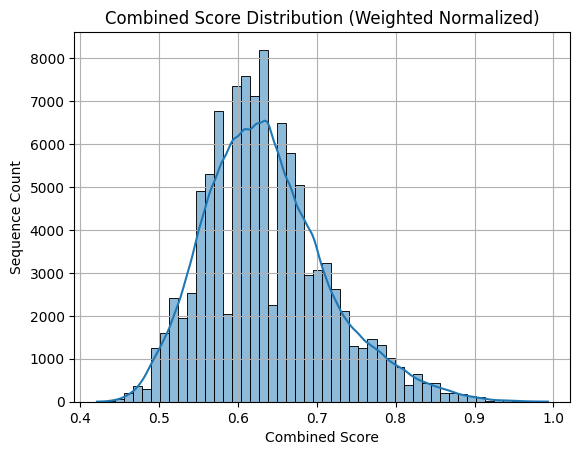

In [35]:
!pip install seaborn
from sklearn.preprocessing import MinMaxScaler

# 选取要归一化的列
score_columns = ["blosum_score", "levenshtein_avg", "freq_penalty"]

# 初始化并拟合 Min-Max Scaler
scaler = MinMaxScaler()
vae_df[[col + "_norm" for col in score_columns]] = scaler.fit_transform(vae_df[score_columns])

# 加权组合打分公式（可自定义权重）
# 越高越好：blosum_score_norm、levenshtein_avg_norm
# 越低越好：freq_penalty_norm → 取 1 - norm
vae_df["combined_score"] = (
    0.4 * vae_df["blosum_score_norm"] +
    0.4 * vae_df["levenshtein_avg_norm"] +
    0.2 * (1 - vae_df["freq_penalty_norm"])
)

# 按照综合得分排序并选出 Top 5000
top_candidates_df = vae_df.sort_values("combined_score", ascending=False).head(5000).reset_index(drop=True)

import seaborn as sns
import matplotlib.pyplot as plt

# 查看综合得分分布
sns.histplot(vae_df["combined_score"], bins=50, kde=True)
plt.title("Combined Score Distribution (Weighted Normalized)")
plt.xlabel("Combined Score")
plt.ylabel("Sequence Count")
plt.grid(True)
plt.show()

In [37]:
# 展示前5条 Top 序列
print(top_candidates_df[["mutated_sequence", "mutation_tag", "combined_score"]].head())
top_candidates_df.to_excel("初筛Top5000序列.xlsx",index=False)

                                    mutated_sequence  \
0  MSKGEELFTGVVPILVELDGDVNGHKFSVAGEGEGDATYGKLTLKF...   
1  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   
2  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   
3  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...   
4  MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...   

                          mutation_tag  combined_score  
0    V68L:E222Q:S30A:Y145H:I136L:K140E        0.992857  
1   N149H:M153L:K214R:V68M:I136L:N121S        0.992857  
2  Y145H:A206S:I128L:N135D:N121H:K140Q        0.985185  
3  M153L:A206S:I128L:I136M:K131E:N135S        0.985185  
4   N149D:M153I:S30K:Y145F:I128L:K131E        0.985185  


## 第六阶段：亮度预测与精筛（从5000 → 2000）

在第五阶段完成 Top5000 多指标候选筛选后，本阶段目标是进一步使用训练好的亮度预测器模型（ResMLP），基于 ESM 表征向量对每条候选序列进行预测排序，选出亮度最优的 Top2000 作为最终提交或结构预测对象。

---

In [6]:
top5000_df = pd.read_excel("初筛Top5000序列.xlsx",engine = 'openpyxl')
candidate_list = top5000_df["mutated_sequence"].astype(str).tolist()
mutation_list = top5000_df["mutation_tag"].astype(str).tolist()

### 6.1 候选序列 ESM 表征向量生成

对 Top5000 序列执行批量推理，获得其 ESM 表征嵌入（N×1280）：

```python
candidate_embeddings_tensor = get_esm_embeddings(
    candidate_list,
    esm_model_pred,
    alphabet_pred,
    batch_converter_pred,
    DEVICE_pred,
    batch_size=prediction_batch_size
)
```

注意：
- 检查 `NaN` 情况，避免模型不收敛或出现非法向量；
- 保存嵌入结果为 `top5000_candidate_embeddings.npy` 便于复用。

---

In [9]:
import time
import torch
import esm # 假设 esm 库已导入
import numpy as np
import pandas as pd
# 假设 model, candidate_list, mutation_list, exclusion_sequences,
# TOP_N_SELECT, BATCH_SIZE, get_esm_embeddings (来自上一步) 已经定义好
# 并且 avGFP_WT_sequence, candidate_position_pool_0based, MAX_MUTATIONS, N_CANDIDATES_TO_GENERATE 也已定义

# --- 修正：定义用于预测的 ESM 模型名称 ---
# !!! 关键：这里必须使用与训练 rf_model 时相同的 ESM 模型 !!!
# 根据之前的日志，rf_model 是用 640 维嵌入训练的 (来自 esm2_t30_150M_UR50D)
PREDICTION_ESM_MODEL_NAME = "esm2_t33_650M_UR50D" # <--- 确认这个模型与训练时一致

print(f"尝试加载用于预测的 ESM 模型: {PREDICTION_ESM_MODEL_NAME}")
start_time = time.time()
try:
    # 加载指定用于预测的 ESM 模型和字母表
    esm_model_pred, alphabet_pred = esm.pretrained.load_model_and_alphabet(PREDICTION_ESM_MODEL_NAME)
    batch_converter_pred = alphabet_pred.get_batch_converter()
    # 重新确定设备 (优先使用 GPU)
    DEVICE_pred = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    esm_model_pred.to(DEVICE_pred)
    esm_model_pred.eval() # 设置模型为评估模式 (关闭 dropout 等)
    print(f"用于预测的 ESM 模型 '{PREDICTION_ESM_MODEL_NAME}' 已加载到 {DEVICE_pred}，耗时 {time.time() - start_time:.2f} 秒。")
except Exception as e:
    print(f"加载 ESM 模型 {PREDICTION_ESM_MODEL_NAME} 时出错: {e}")
    print("请确保 'fair-esm' 已安装，模型名称正确，并且有足够的内存。")
    # 根据需要处理错误，例如退出
    exit()


# --- 6.1 为候选序列生成 ESM 嵌入 ---
print("\n使用预测模型为候选序列生成 ESM 嵌入...")
candidate_embeddings_np = np.array([]) # 初始化为空 numpy 数组

if candidate_list:
    # 确定批次大小 (如果使用GPU，可以尝试更大的批次)
    prediction_batch_size = 8 # 默认使用 CPU 批次大小 (来自之前的定义)
    if DEVICE_pred == torch.device("cuda"):
        # 如果是GPU，可以尝试更大的批次，例如 8, 16 或 32，取决于GPU内存和模型大小
        # 对于较大的模型如 150M，可能需要较小的批次大小
        prediction_batch_size = 16 # 示例值 (根据你的 GPU 内存调整，与训练时用的GPU_BATCH_SIZE可以不同)
        print(f"检测到 GPU，使用 GPU 批次大小: {prediction_batch_size}")
    else:
        print(f"使用 CPU 批次大小: {prediction_batch_size}")

    # *** 修复点：使用正确的函数名 'get_esm_embeddings' ***
    # 传递用于预测的模型、字母表、转换器和设备
    candidate_embeddings_tensor = get_esm_embeddings( # <-- 使用正确的函数名
        candidate_list,
        esm_model_pred,         # 使用预测模型
        alphabet_pred,        # 使用预测模型的字母表
        batch_converter_pred, # 使用预测模型的转换器
        DEVICE_pred,          # 使用预测模型所在的设备 (可能是 cuda 或 cpu)
        batch_size=prediction_batch_size # 使用调整后的批次大小
    )

    # 将嵌入结果转换为 NumPy 数组以用于 scikit-learn 模型
    # .cpu() 确保数据在 CPU 上，然后转换为 numpy
    candidate_embeddings_np = candidate_embeddings_tensor.cpu().numpy()

    print(f"候选序列嵌入的形状: {candidate_embeddings_np.shape}") # 检查维度是否正确 (应为 N x 640)

    # 检查是否有 NaN (如果嵌入过程中出错)
    if np.isnan(candidate_embeddings_np).any():
        print("警告：在候选序列嵌入中发现 NaN 值。将移除相应的候选序列。")
        nan_mask = np.isnan(candidate_embeddings_np).any(axis=1)
        # 需要同时过滤 candidate_list, mutation_list 和 embeddings
        # 使用列表推导式进行过滤
        original_count = len(candidate_list)
        candidate_list = [seq for i, seq in enumerate(candidate_list) if not nan_mask[i]]
        mutation_list = [mut for i, mut in enumerate(mutation_list) if not nan_mask[i]]
        candidate_embeddings_np = candidate_embeddings_np[~nan_mask]
        print(f"因 NaN 嵌入移除了 {original_count - len(candidate_list)} 个候选序列。")
        print(f"剩余候选序列数量: {len(candidate_list)}")
        print(f"过滤后的候选序列嵌入形状: {candidate_embeddings_np.shape}")

else:
    # candidate_embeddings_np 已经初始化为空数组
    print("上一步没有生成候选序列，跳过预测。")
np.save("top5000_candidate_embeddings.npy", candidate_embeddings_np)

尝试加载用于预测的 ESM 模型: esm2_t33_650M_UR50D
用于预测的 ESM 模型 'esm2_t33_650M_UR50D' 已加载到 cuda，耗时 9.58 秒。

使用预测模型为候选序列生成 ESM 嵌入...
检测到 GPU，使用 GPU 批次大小: 16
正在为 5000 个序列生成嵌入，共 313 个批次（批次大小: 16，设备: cuda）...
  已处理批次 10/313... (耗时: 9.21 秒)
  已处理批次 20/313... (耗时: 18.08 秒)
  已处理批次 30/313... (耗时: 26.94 秒)
  已处理批次 40/313... (耗时: 35.82 秒)
  已处理批次 50/313... (耗时: 44.69 秒)
  已处理批次 60/313... (耗时: 53.55 秒)
  已处理批次 70/313... (耗时: 62.42 秒)
  已处理批次 80/313... (耗时: 71.27 秒)
  已处理批次 90/313... (耗时: 80.15 秒)
  已处理批次 100/313... (耗时: 89.02 秒)
  已处理批次 110/313... (耗时: 97.90 秒)
  已处理批次 120/313... (耗时: 106.77 秒)
  已处理批次 130/313... (耗时: 115.64 秒)
  已处理批次 140/313... (耗时: 124.50 秒)
  已处理批次 150/313... (耗时: 133.37 秒)
  已处理批次 160/313... (耗时: 142.26 秒)
  已处理批次 170/313... (耗时: 151.14 秒)
  已处理批次 180/313... (耗时: 160.02 秒)
  已处理批次 190/313... (耗时: 168.89 秒)
  已处理批次 200/313... (耗时: 177.75 秒)
  已处理批次 210/313... (耗时: 186.62 秒)
  已处理批次 220/313... (耗时: 195.49 秒)
  已处理批次 230/313... (耗时: 204.38 秒)
  已处理批次 240/313... (耗时: 213.25 秒)
  已处理批次 250/3

### 6.2 使用 ResMLP 模型进行亮度预测

加载已训练的亮度预测模型：

- 输入维度由 `candidate_embeddings_np.shape[1]` 自动确认（应为 1280）；
- 使用 `.eval()` 模式关闭 Dropout 以保证稳定性；
- 使用 `.to(device)` 将模型迁移到相应计算设备。

在无梯度模式下进行亮度预测：

```python
with torch.no_grad():
    predicted_brightness = model(tensor_input).cpu().numpy().tolist()
```

---

In [24]:
# --- 6.2 预测亮度 ---
candidate_embeddings_np = np.load("top5000_candidate_embeddings.npy")

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrightnessRegressor(input_dim=candidate_embeddings_np.shape[1]).to(device)
model.load_state_dict(torch.load("best_brightness_model.pt", map_location=device))
model.eval()

predicted_brightness = []
if candidate_embeddings_np.shape[0] > 0 and len(candidate_list) == candidate_embeddings_np.shape[0]:
    print("\n正在为候选序列预测亮度（使用 ResMLP）...")
    try:
        with torch.no_grad():
            tensor_input = torch.tensor(candidate_embeddings_np, dtype=torch.float32).to(device)
            predicted_brightness = model(tensor_input).cpu().numpy().tolist()
        print("预测完成。")
    except Exception as e:
        print(f"ResMLP 模型预测期间发生错误: {e}")
        predicted_brightness = []
else:
    print("候选列表或嵌入向量为空，或数量不匹配，无法进行预测。")



正在为候选序列预测亮度（使用 ResMLP）...
预测完成。


### 6.3 Top2000 精筛与保存

根据 `PredictedBrightness` 对所有候选进行降序排序：

- 过滤掉在 `exclusion_list` 中的非法或重复序列；
- 插入 `Sequence ID` 标识；
- 提取最终字段 `["Sequence ID", "Mutations", "Sequence", "PredictedBrightness"]`；
- 保存为标准提交格式 `Top2000_Brightness_Selected.csv`。

```python
final_candidates_formatted.to_csv("Top2000_Brightness_Selected.csv", index=False)
```

---

In [25]:
# --- 6.3 组合结果并筛选 ---
Top_N_SELECT=2000

final_candidates_formatted = pd.DataFrame() # 初始化为空 DataFrame

# 只有在成功生成预测并且数量与候选列表匹配时才继续
if len(candidate_list) > 0 and len(predicted_brightness) > 0 and len(candidate_list) == len(predicted_brightness):
    # 创建包含序列、突变和预测值的 DataFrame
    results_df = pd.DataFrame({
        'Sequence': candidate_list,
        'Mutations': mutation_list, # 确保 mutation_list 与 candidate_list 保持同步
        'PredictedBrightness': predicted_brightness
    })
    print(len(results_df))
    # 过滤掉排除列表中的序列
    print(f"\n根据排除列表 ({len(exclusion_sequences)} 个序列) 进行过滤...")
    initial_candidate_count = len(results_df)
    # 确保比较的是字符串类型
    results_df = results_df[~results_df['Sequence'].astype(str).isin(exclusion_sequences)]
    removed_count = initial_candidate_count - len(results_df)
    if removed_count > 0:
        print(f"移除了 {removed_count} 个在排除列表中的序列。")
    else:
        print("候选列表中的序列均不在排除列表中。")

    # 按预测亮度降序排序
    results_df = results_df.sort_values(by='PredictedBrightness', ascending=False)

    # 选择 Top N 个结果
    final_candidates = results_df.head(2000).copy() # 使用 .copy() 避免 SettingWithCopyWarning

    print(f"\n预测出的 Top {min(2000, len(final_candidates))} 个候选序列 (已排除):") # 显示实际选出的数量

    if not final_candidates.empty:
        # 为了更清晰地展示，可以添加一个 ID 列
        final_candidates.insert(0, 'Sequence ID', [f'Candidate_{i+1}' for i in range(len(final_candidates))])
        # 调整列顺序以符合提交格式要求
        final_candidates_formatted = final_candidates[['Sequence ID', 'Mutations', 'Sequence', 'PredictedBrightness']]
        # 使用 display 或 print 显示 DataFrame
        try:
            from IPython.display import display
            display(final_candidates_formatted) # 在 Jupyter 环境中友好显示
        except ImportError:
            print(final_candidates_formatted.to_string()) # 在非 IPython 环境中打印完整 DataFrame
    else:
        print("经过过滤和筛选后，没有剩余的候选序列。")

        if not candidate_list:
            print("\n没有生成候选序列或候选序列在预测前已被过滤掉。")
        elif not predicted_brightness:
            print("\n预测步骤失败或没有产生结果。请检查之前的错误信息。")
        else: # candidate_list 和 predicted_brightness 长度不匹配
            print("\n错误：最终候选序列数量与预测结果数量不匹配。无法继续处理。")
final_candidates_formatted.to_csv("Top2000_Brightness_Selected.csv", index=False)
print("已保存 Top2000 候选序列到 Top2000_Brightness_Selected.csv")

# --- 清理预测模型占用的内存 ---
print("\n清理预测模型内存...")

for var_name in ["esm_model_pred", "alphabet_pred", "batch_converter_pred"]:
    if var_name in globals():
        del globals()[var_name]

if 'candidate_embeddings_tensor' in locals():
    del candidate_embeddings_tensor
if 'candidate_embeddings_np' in locals():
    del candidate_embeddings_np
if 'DEVICE_pred' in globals() and DEVICE_pred == torch.device("cuda"):
    print("清空CUDA缓存...")
    torch.cuda.empty_cache()

print("预测模型清理完成。")


5000

根据排除列表 (739 个序列) 进行过滤...
候选列表中的序列均不在排除列表中。

预测出的 Top 2000 个候选序列 (已排除):


,Sequence ID,Mutations,Sequence,PredictedBrightness
4293,Candidate_1,M153I:A206W:T203I:I136L:K131E:N121Y,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.162509
1617,Candidate_2,N149S:S30A:Y145L:A206I:T203L:K140Q,MSKGEELFTGVVPILVELDGDVNGHKFSVAGEGEGDATYGKLTLKF...,3.148169
1330,Candidate_3,K214Q:V68L:V163Q:F130L:K131D:N121S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.147022
3296,Candidate_4,N149D:M153S:T203L:K131E:N135E:N121A,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.139331
2297,Candidate_5,M153I:K214E:T203L:K131D:N121S:K140Y,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.136574
...,...,...,...,...
436,Candidate_1996,N149H:N212S:A206M:T203K:I136L:N135S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.092048
4169,Candidate_1997,K214E:N212D:A206M:K131Q:N135A,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.092048
566,Candidate_1998,N212D:V68S:I136T:N135H:N121S:K126Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.092044
535,Candidate_1999,V68L:S30N:I128L:K131Q:N135D,MSKGEELFTGVVPILVELDGDVNGHKFSVNGEGEGDATYGKLTLKF...,3.092038


已保存 Top2000 候选序列到 Top2000_Brightness_Selected.csv

清理预测模型内存...
清空CUDA缓存...
预测模型清理完成。


In [26]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import joblib
# --- 预测亮度 ---
candidate_embeddings_np = np.load("top5000_candidate_embeddings.npy")

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrightnessRegressor(input_dim=candidate_embeddings_np.shape[1]).to(device)
model.load_state_dict(torch.load("brightness_model_finetuned_on_high.pt", map_location=device))
model.eval()

predicted_brightness = []
if candidate_embeddings_np.shape[0] > 0 and len(candidate_list) == candidate_embeddings_np.shape[0]:
    print("\n正在为候选序列预测亮度（使用 ResMLP_Fine_Tuning）...")
    try:
        with torch.no_grad():
            tensor_input = torch.tensor(candidate_embeddings_np, dtype=torch.float32).to(device)
            predicted_brightness = model(tensor_input).cpu().numpy().tolist()
        print("预测完成。")
    except Exception as e:
        print(f"ResMLP 模型预测期间发生错误: {e}")
        predicted_brightness = []
else:
    print("候选列表或嵌入向量为空，或数量不匹配，无法进行预测。")


正在为候选序列预测亮度（使用 ResMLP_Fine_Tuning）...
预测完成。


In [27]:
# --- 6.3 组合结果并筛选 ---
Top_N_SELECT=2000

final_candidates_formatted = pd.DataFrame() # 初始化为空 DataFrame

# 只有在成功生成预测并且数量与候选列表匹配时才继续
if len(candidate_list) > 0 and len(predicted_brightness) > 0 and len(candidate_list) == len(predicted_brightness):
    # 创建包含序列、突变和预测值的 DataFrame
    results_df = pd.DataFrame({
        'Sequence': candidate_list,
        'Mutations': mutation_list, # 确保 mutation_list 与 candidate_list 保持同步
        'PredictedBrightness': predicted_brightness
    })
    print(len(results_df))
    # 过滤掉排除列表中的序列
    print(f"\n根据排除列表 ({len(exclusion_sequences)} 个序列) 进行过滤...")
    initial_candidate_count = len(results_df)
    # 确保比较的是字符串类型
    results_df = results_df[~results_df['Sequence'].astype(str).isin(exclusion_sequences)]
    removed_count = initial_candidate_count - len(results_df)
    if removed_count > 0:
        print(f"移除了 {removed_count} 个在排除列表中的序列。")
    else:
        print("候选列表中的序列均不在排除列表中。")

    # 按预测亮度降序排序
    results_df = results_df.sort_values(by='PredictedBrightness', ascending=False)

    # 选择 Top N 个结果
    final_candidates = results_df.head(2000).copy() # 使用 .copy() 避免 SettingWithCopyWarning

    print(f"\n预测出的 Top {min(2000, len(final_candidates))} 个候选序列 (已排除):") # 显示实际选出的数量

    if not final_candidates.empty:
        # 为了更清晰地展示，可以添加一个 ID 列
        final_candidates.insert(0, 'Sequence ID', [f'Candidate_{i+1}' for i in range(len(final_candidates))])
        # 调整列顺序以符合提交格式要求
        final_candidates_formatted = final_candidates[['Sequence ID', 'Mutations', 'Sequence', 'PredictedBrightness']]
        # 使用 display 或 print 显示 DataFrame
        try:
            from IPython.display import display
            display(final_candidates_formatted) # 在 Jupyter 环境中友好显示
        except ImportError:
            print(final_candidates_formatted.to_string()) # 在非 IPython 环境中打印完整 DataFrame
    else:
        print("经过过滤和筛选后，没有剩余的候选序列。")

        if not candidate_list:
            print("\n没有生成候选序列或候选序列在预测前已被过滤掉。")
        elif not predicted_brightness:
            print("\n预测步骤失败或没有产生结果。请检查之前的错误信息。")
        else: # candidate_list 和 predicted_brightness 长度不匹配
            print("\n错误：最终候选序列数量与预测结果数量不匹配。无法继续处理。")
final_candidates_formatted.to_csv("Top2000_Brightness_Selected_FineTune.csv", index=False)
print("已保存 Top2000 候选序列到 Top2000_Brightness_Selected_FineTune.csv")

# --- 清理预测模型占用的内存 ---
print("\n清理预测模型内存...")

for var_name in ["esm_model_pred", "alphabet_pred", "batch_converter_pred"]:
    if var_name in globals():
        del globals()[var_name]

if 'candidate_embeddings_tensor' in locals():
    del candidate_embeddings_tensor
if 'candidate_embeddings_np' in locals():
    del candidate_embeddings_np
if 'DEVICE_pred' in globals() and DEVICE_pred == torch.device("cuda"):
    print("清空CUDA缓存...")
    torch.cuda.empty_cache()

print("预测模型清理完成。")


5000

根据排除列表 (739 个序列) 进行过滤...
候选列表中的序列均不在排除列表中。

预测出的 Top 2000 个候选序列 (已排除):


,Sequence ID,Mutations,Sequence,PredictedBrightness
3406,Candidate_1,N149H:E222K:A206N:F130T:K140I:K126E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.663651
4702,Candidate_2,N149H:N212E:L64F:F130T:K131T:N135K,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.569467
3896,Candidate_3,N149H:M153I:E222K:T203G:K126Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.421463
1289,Candidate_4,N149D:M153V:K214Q:V68E:Y145F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.907406
2970,Candidate_5,N149H:K214E:A206E:K131T:K126Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.802310
...,...,...,...,...
1427,Candidate_1996,M153I:A206S:F130W:I128T:N135S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.328672
4724,Candidate_1997,N149S:M153V:V68E:L64K:S30K:A206E,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,3.328447
3258,Candidate_1998,L64E:S30N:A206E:I128T:K131E:K126Q,MSKGEELFTGVVPILVELDGDVNGHKFSVNGEGEGDATYGKLTLKF...,3.328374
4853,Candidate_1999,N149S:K214Q:F130W:K140Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.328326


已保存 Top2000 候选序列到 Top2000_Brightness_Selected_FineTune.csv

清理预测模型内存...
清空CUDA缓存...
预测模型清理完成。


---
## 第七阶段：PLM融合打分与结构一致性精筛（2000 → 300 ∪ 300）

### 7.1 蛋白语言模型融合打分（ESM-1b + Tranception）

本子阶段通过两个训练于不同语料和策略的蛋白语言模型对候选序列进行打分：

- **ESM-1b Flat**：基于 Facebook 的预训练语言模型，使用 `log-likelihood` 评估序列天然性；
- **Tranception**：基于 Transformer + 自动回归建模策略的蛋白语言模型，适用于泛化打分。
#### 流程概述：

1. **加载 ESM-1b 模型**
   - 使用 HuggingFace 接口加载 `esm1b_flat` 本地模型；
   - 对 Top2000 每条序列计算其 token-level `log-likelihood` 和 `perplexity`。

2. **加载 Tranception 模型**
   - 使用 `Tranception_Medium` 版本；
   - 对每条序列计算其 log-likelihood 和 perplexity，输出保存在 `tranception_scores.csv`。

3. **三方打分融合**
   - 将亮度预测结果（`PredictedBrightness`）与上述两种语言模型的打分合并；
   - 使用 `StandardScaler` 对三项打分结果（亮度、ESM、Tranception）进行标准化；
   - 构建融合打分：
     ```math
     Final\_Score = mean(Brightness\_z, ESM\_LL\_z, Tranception\_LL\_z)
     ```
     默认采用等权重。

4. **选出前300条高分序列**
   - 根据 `Final_Score` 降序排列，选择前300条序列作为语言模型层面可信候选；
   - 保存为 `top300_fused_scored.csv`。

#### 亮点：
- 融合亮度预测 + 两种语言建模视角，确保筛选出的序列既具潜在功能又具自然合理性；
- 利用 ESM 提供的 token 级别 likelihood 和 Tranception 提供的 full-sequence log-likelihood 互补增强判断；
- 融合策略灵活，可根据评估权重自定义扩展。

---


In [ ]:
import zipfile
import os

zip_path = "esm1b.zip"  # 如果你命名成别的，记得改这里
extract_dir = "esm1b"

# 解压模型压缩包
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f" 模型已解压至: {extract_dir}")


In [29]:
from transformers import EsmTokenizer, EsmForMaskedLM
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "esm1b_flat"
tokenizer = EsmTokenizer.from_pretrained(model_path)
model = EsmForMaskedLM.from_pretrained(model_path).to(device)
model.eval()

print(" 模型加载成功")

 模型加载成功


In [4]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from transformers import EsmForMaskedLM, EsmTokenizer

# ----------------- 参数设置 -----------------
CSV_PATH = "Top2000_Brightness_Selected_FineTune.csv"  # 输入CSV路径
OUTPUT_PATH = "esm1b_scores.csv"                        # 输出打分文件
BATCH_SIZE = 1                                          # HuggingFace不支持变长批次，建议设置为1

# ----------------- 初始化模型与设备 -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "esm1b_flat"  # 改为你解压的真实路径
tokenizer = EsmTokenizer.from_pretrained(model_path)
model = EsmForMaskedLM.from_pretrained(model_path).to(device)
model.eval()

# ----------------- 读取序列 -----------------
df = pd.read_csv(CSV_PATH)
assert "Sequence" in df.columns, "缺少 'Sequence' 列"
sequences = df["Sequence"].tolist()

# ----------------- 打分函数 -----------------
def compute_ll_ppl(sequence: str):
    """计算单个序列的 log-likelihood 和 perplexity"""
    try:
        inputs = tokenizer(sequence, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            log_likelihood = log_probs.gather(2, input_ids.unsqueeze(-1)).squeeze(-1)

            mask = attention_mask.bool()
            ll_sum = log_likelihood[mask].sum().item()
            token_count = mask.sum().item()
            avg_log_likelihood = ll_sum / token_count
            perplexity = torch.exp(torch.tensor(-avg_log_likelihood)).item()

        return avg_log_likelihood, perplexity

    except Exception as e:
        print(f"[Error] 序列处理失败: {e}")
        return None, None

# ----------------- 批量处理 -----------------
results = []
for seq in tqdm(sequences, desc="Scoring Sequences"):
    ll, ppl = compute_ll_ppl(seq)
    results.append({
        "Sequence": seq,
        "LogLikelihood": ll,
        "Perplexity": ppl
    })

# ----------------- 保存结果 -----------------
out_df = pd.DataFrame(results)
out_df.to_csv(OUTPUT_PATH, index=False)
print(f"结果已保存为 {OUTPUT_PATH}")

Scoring Sequences: 100%|██████████| 2000/2000 [02:21<00:00, 14.15it/s]

结果已保存为 esm1b_scores.csv


In [ ]:
import zipfile
import os

# 解压路径
base_dir = "/home/ma-user/work"

# === 解压模型 checkpoint ===
ckpt_zip_path = os.path.join(base_dir, "Tranception_Medium_checkpoint.zip")
ckpt_extract_dir = os.path.join(base_dir, "tranception_medium")

with zipfile.ZipFile(ckpt_zip_path, 'r') as zip_ref:
    zip_ref.extractall(ckpt_extract_dir)

print("解压 Tranception_Medium_checkpoint.zip 完成")

# === 解压代码文件 ===
code_zip_path = os.path.join(base_dir, "Tranception-main.zip")

with zipfile.ZipFile(code_zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_dir)

# 移动子目录 tranception-main/tranception → ./tranception
import shutil

src = os.path.join(base_dir, "Tranception-main", "tranception")
dst = os.path.join(base_dir, "tranception")

if not os.path.exists(dst):
    shutil.move(src, dst)
    print("已将 tranception 移动到工作目录")
else:
    print("tranception 目录已存在，跳过移动")
print("所有文件解压完成")

In [ ]:
!pip install datasets
!pip install transformers
!pip install biopython

In [1]:
import os
import torch
import math
import pandas as pd
from tqdm import tqdm
from tranception.inference_utils import load_model_and_alphabet, score_sequence

# === 配置路径 ===
MODEL_DIR = "Tranception_Medium"
CSV_PATH = "Top2000_Brightness_Selected_FineTune.csv"
OUTPUT_PATH = "tranception_scores.csv"

# === 加载模型 ===
print(f"Loading Tranception model from {MODEL_DIR} ...")
model, alphabet = load_model_and_alphabet(MODEL_DIR,
                                          model_name="Tranception_Medium",
                                          use_gpu=torch.cuda.is_available())

/home/ma-user/anaconda3/envs/PyTorch-2.0.0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ma-user/anaconda3/envs/PyTorch-2.0.0/lib/python3.9/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Loading Tranception model from Tranception_Medium ...


In [2]:
# === 加载数据 ===
df = pd.read_csv(CSV_PATH)
assert "Sequence" in df.columns, "CSV文件中缺少'Sequence'列"
sequences = df["Sequence"].tolist()
ids = df["Sequence ID"].tolist() if "Sequence ID" in df.columns else [f"Seq_{i}" for i in range(len(sequences))]
test_seq = df["Sequence"].iloc[1]
_ = score_sequence(test_seq, model, alphabet)
test_seq = df["Sequence"].iloc[1]
log_likelihood = score_sequence(test_seq, model, alphabet)
log_likelihood = score_sequence(test_seq, model, alphabet)
log_avg_prob = log_likelihood[0]
print("Log-likelihood (avg):", log_avg_prob)
print("Perplexity:", math.exp(-log_avg_prob))

Log-likelihood (avg): -4.394589900970459
Perplexity: 81.01140125246286


In [3]:
# === 打分并计算 perplexity ===
results = []
print("Scoring sequences using Tranception...")
for i, seq in tqdm(enumerate(sequences), total=len(sequences), desc="Scoring"):
    try:
        log_prob, total_nll, length = score_sequence(seq=seq,
                                                     model=model,
                                                     alphabet=alphabet,
                                                     scoring_matrices=None,
                                                     temperature=1.0,
                                                     return_log_likelihood=True)
        perplexity = math.exp(total_nll / length) if log_prob is not None else None
    except Exception as e:
        print(f"[Error] {ids[i]}: {e}")
        log_prob = None
        perplexity = None

    results.append({
        "Sequence ID": ids[i],
        "Sequence": seq,
        "Tranception_LogLikelihood": log_prob,
        "Tranception_Perplexity": perplexity
    })

# === 保存结果 ===
out_df = pd.DataFrame(results)
out_df.to_csv(OUTPUT_PATH, index=False)
print(f"Done. Results saved to {OUTPUT_PATH}")

Scoring sequences using Tranception...


Scoring: 100%|██████████| 2000/2000 [01:49<00:00, 18.26it/s]

Done. Results saved to tranception_scores.csv


In [5]:
# 模拟读取前面三个来源的分数文件
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 文件路径（假设用户上传的文件）
brightness_path = "Top2000_Brightness_Selected_FineTune.csv"
esm_score_path = "esm1b_scores.csv"
tranception_score_path = "tranception_scores.csv"

# 读取数据
brightness_df = pd.read_csv(brightness_path)
esm_df = pd.read_csv(esm_score_path)
tranception_df = pd.read_csv(tranception_score_path)
# 可选：检查重复行
print("重复序列数量：", brightness_df["Sequence"].duplicated().sum())
print("ESM  重复序列数量：", esm_df["Sequence"].duplicated().sum())
print("Tranception 重复序列数量：", tranception_df["Sequence"].duplicated().sum())

# 合并三方数据
merged_df = brightness_df.merge(esm_df, on="Sequence", how="inner").merge(tranception_df, on="Sequence", how="inner")

# 标准化三项打分：亮度、ESM-1b LL、Tranception LL
scaler = StandardScaler()
merged_df[["Brightness_z", "ESM_LL_z", "Tranception_LL_z"]] = scaler.fit_transform(
    merged_df[["PredictedBrightness", "LogLikelihood", "Tranception_LogLikelihood"]]
)

# 融合打分：默认等权重 1:1:1
merged_df["Final_Score"] = merged_df[["Brightness_z", "ESM_LL_z", "Tranception_LL_z"]].mean(axis=1)

# 选出 Top300
top300_df = merged_df.sort_values("Final_Score", ascending=False).head(300).reset_index(drop=True)

# 展示输出

top300_df.to_csv("top300_fused_scored.csv", index=False)
print("the saving is Done")
top300_df.head()

重复序列数量： 0
ESM  重复序列数量： 0
Tranception 重复序列数量： 0
the saving is Done


,Sequence ID_x,Mutations,Sequence,PredictedBrightness,LogLikelihood,Perplexity,Sequence ID_y,Tranception_LogLikelihood,Tranception_Perplexity,Brightness_z,ESM_LL_z,Tranception_LL_z,Final_Score
0,Candidate_2,N149H:N212E:L64F:F130T:K131T:N135K,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.569467,-0.482935,1.620825,Candidate_2,-4.394590,81.011387,13.995412,-0.453788,0.308435,4.616686
1,Candidate_1,N149H:E222K:A206N:F130T:K140I:K126E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.663651,-0.475299,1.608495,Candidate_1,-4.496346,89.688818,15.166114,1.030583,-2.789420,4.469093
2,Candidate_3,N149H:M153I:E222K:T203G:K126Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.421463,-0.488530,1.629919,Candidate_3,-4.439451,84.728376,12.155747,-1.541269,-1.057299,3.185726
3,Candidate_4,N149D:M153V:K214Q:V68E:Y145F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.907406,-0.479723,1.615627,Candidate_4,-4.381681,79.972316,5.766112,0.170630,0.701432,2.212725
4,Candidate_9,E222Q:T203L:I128K:I136M:N135S:K140I,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.705425,-0.472896,1.604635,Candidate_9,-4.380309,79.862710,3.255525,1.497538,0.743196,1.832086


### 7.2 结构一致性打分筛选（ESMFold + ProteinMPNN）

本子阶段从结构角度对 Top2000 候选序列进行评估，旨在筛选出结构可信、序列与结构一致性较高的 Top300 条候选序列，用于后续 AlphaFold 精预测和实验候选优选。

---

#### 流程概述：

本流程可分为两个子模块：

---

#### 7.2.1 结构预测（ESMFold）

- 使用 [ESMFold](https://github.com/facebookresearch/esm) 离线模型（`esmfold_v1_offline`）对 Top2000 序列逐条进行结构预测；
- 自动跳过已完成预测的 `.pdb` 文件，支持断点续跑；
- 每条序列输出为一个标准 `.pdb` 文件，保存在 `esmfold_outputs/` 文件夹中；
- 最终得到约 1900+ 条合法结构文件用于后续打分。

---

#### 7.2.2 结构一致性打分（ProteinMPNN）

- 加载 ProteinMPNN 原始模型权重（`v_48_020.pt`）；
- 对每个结构 `.pdb` 文件执行：
  - **逆折叠重建**：使用 ProteinMPNN 对结构中的 backbone 进行序列预测；
  - **打分输出**：
    - `MPNN_LL`: 基于 mask 的局部对数似然；
    - `MPNN_Global_LL`: 全局打分指标，衡量整条序列与结构的一致性；
- 将打分结果与原亮度预测结果合并。

---

#### 融合打分与筛选策略：

- 使用 `StandardScaler` 对 `PredictedBrightness` 与 `MPNN_Global_LL` 进行标准化；
- 构建融合得分：
  ```math
  FusionScore = Brightness_z + MPNN_z
  ```
  表示在亮度与结构一致性之间寻找均衡的高质量候选；
- 按照 `FusionScore` 降序排列，选出 Top300；
- 保存为 `brightness_mpnn_top300.csv`。

---

#### 阶段亮点：

- **结构级约束强化**：相比仅依赖语言模型，MPNN 能有效过滤出结构稳定性与序列天然性双优的蛋白；
- **完整打分闭环**：通过“序列 → 结构 → 逆折叠”的闭环流程，建立从功能预测到结构可靠性的多重验证；
- **并行执行灵活性强**：ESMFold 与 MPNN 可并行部署，适配集群或高性能 GPU 环境。

---

#### 与 7.1 的整合：

最终将与 7.1 中的语言模型 Top300 序列进行 **并集融合**（共约 400~600 条），以进入第八阶段



In [ ]:
import zipfile
import os

zip_path = "/home/ma-user/work/esmfold_v1_offline.zip"
extract_dir = "/home/ma-user/work/esmfold_v1_offline"

# 解压
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("解压完成！")


In [ ]:
import torch
import os
import pandas as pd
from tqdm import tqdm
from transformers import EsmForProteinFolding, AutoTokenizer

# ====== 路径配置 ======
CSV_PATH = "Top2000_Brightness_Selected_FineTune.csv"
OUT_DIR = "esmfold_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ====== 加载模型与Tokenizer ======
model_dir = "/home/ma-user/work/esmfold_v1_offline"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EsmForProteinFolding.from_pretrained(model_dir, use_safetensors=False).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# ====== 读取序列 ======
df = pd.read_csv(CSV_PATH)
sequences = df["Sequence"].tolist()
ids = df["Sequence ID"].tolist() if "Sequence ID" in df.columns else [f"seq_{i}" for i in range(len(sequences))]

# ====== 获取已完成的 PDB 文件名 ======
existing_pdbs = set(f.split(".")[0] for f in os.listdir(OUT_DIR) if f.endswith(".pdb"))

# ====== 筛选未完成的序列 ======
pending_items = [(i, s) for i, s in zip(ids, sequences) if i not in existing_pdbs]
print(f"已完成：{len(existing_pdbs)} 条；待预测：{len(pending_items)} 条")

# ====== 开始预测并保存 PDB ======
for seq_id, seq in tqdm(pending_items, desc="Continuing with ESMFold"):
    try:
        with torch.no_grad():
            pdb_str = model.infer_pdb(seq)
        out_path = os.path.join(OUT_DIR, f"{seq_id}.pdb")
        with open(out_path, "w") as f:
            f.write(pdb_str)
    except Exception as e:
        print(f"[Error] Failed on {seq_id}: {e}")


In [6]:
!git clone https://github.com/dauparas/ProteinMPNN.git
%cd ProteinMPNN

Cloning into 'ProteinMPNN'...
remote: Enumerating objects: 634, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 634 (delta 185), reused 154 (delta 154), pack-reused 395 (from 1)
Receiving objects: 100% (634/634), 119.91 MiB | 678.00 KiB/s, done.
Resolving deltas: 100% (285/285), done.
/home/ma-user/work/ProteinMPNN


In [3]:
from ProteinMPNN.protein_mpnn_utils import parse_PDB, StructureDatasetPDB

pdb_dict = parse_PDB("Candidate_1001.pdb", ca_only=False)
dataset = StructureDatasetPDB(pdb_dict, max_length=10000)

print("成功读取结构！包含序列链数：", len(pdb_dict[0].keys()))

成功读取结构！包含序列链数： 5


In [23]:
from ProteinMPNN.protein_mpnn_utils import parse_PDB, StructureDatasetPDB
import pandas as pd
import json
import os
from tqdm import tqdm  # 添加 tqdm

# === 数据路径配置 ===
df = pd.read_csv("Top2000_Brightness_Selected_FineTune.csv")
pdb_dir = "esmfold_outputs"
jsonl_valid_path = "mpnn_valid_input.jsonl"

valid_entries = []
invalid_ids = []


for i, row in tqdm(df.iterrows(), total=len(df), desc="结构合法性检查"):
    seq_id = row["Sequence ID"]
    seq = row["Sequence"]
    pdb_path = os.path.join(pdb_dir, f"{seq_id}.pdb")
    
    if not os.path.isfile(pdb_path):
        continue

    try:
        pdb_dict = parse_PDB(pdb_path,input_chain_list=["A"],ca_only=False)
        dataset = StructureDatasetPDB(pdb_dict, max_length=10000)
        valid_entries.append({
            "name": seq_id,
            "pdb_path": pdb_path,
            "seq": seq
        })
    except Exception as e:
        invalid_ids.append(seq_id)
        print(f"[跳过] {seq_id}: 结构无法用于MPNN ({e})")

# === 写入 JSONL 文件 ===
with open(jsonl_valid_path, "w") as f:
    for entry in valid_entries:
        f.write(json.dumps(entry) + "\n")

print(f"\n 合法结构数: {len(valid_entries)}")
print(f" 无效结构数: {len(invalid_ids)}")


结构合法性检查: 100%|██████████| 2000/2000 [00:18<00:00, 110.92it/s]


 合法结构数: 2000
 无效结构数: 0


In [3]:
!python ProteinMPNN/protein_mpnn_run.py \
  --pdb_path Candidate_1001.pdb \
  --pdb_path_chains A \
  --out_folder mpnn_outputs \
  --score_only 1 \
  --num_seq_per_target 1 \
  --batch_size 1 \
  --model_name v_48_020

----------------------------------------
chain_id_jsonl is NOT loaded
----------------------------------------
fixed_positions_jsonl is NOT loaded
----------------------------------------
pssm_jsonl is NOT loaded
----------------------------------------
omit_AA_jsonl is NOT loaded
----------------------------------------
bias_AA_jsonl is NOT loaded
----------------------------------------
tied_positions_jsonl is NOT loaded
----------------------------------------
bias by residue dictionary is not loaded, or not provided
----------------------------------------
----------------------------------------
Number of edges: 48
Training noise level: 0.2A
Score for Candidate_1001 from PDB, mean: 2.3080, std: 0.0000, sample size: 1,  global score, mean: 2.3080, std: 0.0000, sample size: 1


In [13]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from ProteinMPNN.protein_mpnn_utils import ProteinMPNN, parse_PDB, StructureDatasetPDB, tied_featurize, _scores

# ===== 配置 =====
pdb_dir = "esmfold_outputs"
model_path = "ProteinMPNN/vanilla_model_weights/v_48_020.pt"
output_csv = "fast_mpnn_scores.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ca_only = False

# === 固定参数（来源于 run.py）===
hidden_dim = 128
num_layers = 3
backbone_noise = 0.0

# === 加载 checkpoint ===
checkpoint = torch.load(model_path, map_location=device)

# === 正确初始化模型 ===
model = ProteinMPNN(
    ca_only=ca_only,
    num_letters=21,
    node_features=hidden_dim,
    edge_features=hidden_dim,
    hidden_dim=hidden_dim,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    augment_eps=backbone_noise,
    k_neighbors=checkpoint["num_edges"]
).to(device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# ===== 定义打分函数 =====
def fast_score(pdb_path):
    try:
        pdb_data = parse_PDB(pdb_path, input_chain_list=None, ca_only=False)

        dataset = StructureDatasetPDB(pdb_data)

        protein = dataset[0]

        batch = [protein]

        with torch.no_grad():
            X, S, mask, lengths, chain_M, chain_encoding_all, _, _, _, _, chain_M_pos, _, residue_idx, *_ = \
            tied_featurize(batch, device, None, None, None, None, None, ca_only)

            randn = torch.randn(chain_M.shape, device=device)
            log_probs = model(X, S, mask, chain_M * chain_M_pos,
            residue_idx, chain_encoding_all, randn)

            native_score = _scores(S, log_probs, mask * chain_M * chain_M_pos).mean().item()
            global_score = _scores(S, log_probs, mask).mean().item()

        return native_score, global_score
    except Exception as e:
        print(f"[Error] {os.path.basename(pdb_path)}: {e}")
        return None, None

# ===== 批量打分 =====
records = []
pdb_list = sorted([f for f in os.listdir(pdb_dir) if f.endswith(".pdb")])
for fname in tqdm(pdb_list, desc="Fast MPNN scoring"):
    path = os.path.join(pdb_dir, fname)
    seq_id = fname.replace(".pdb", "")
    mpnn_ll, mpnn_global = fast_score(path)
    records.append({
        "Sequence ID": seq_id,
        "MPNN_LL": mpnn_ll,
        "MPNN_Global_LL": mpnn_global
    })

df = pd.DataFrame(records)
df.to_csv(output_csv, index=False)
print(f"Done! Saved to {output_csv}")


Fast MPNN scoring: 100%|██████████| 2000/2000 [14:19<00:00,  2.33it/s]

Done! Saved to fast_mpnn_scores.csv


In [14]:
df.head()

,Sequence ID,MPNN_LL,MPNN_Global_LL
0,Candidate_1,2.211623,2.211623
1,Candidate_10,2.153116,2.153116
2,Candidate_100,2.187891,2.187891
3,Candidate_1000,2.288170,2.288170
4,Candidate_1001,2.322528,2.322528


In [ ]:
from ProteinMPNN.protein_mpnn_utils import parse_PDB

# 示例：检查 Candidate_1000.pdb
pdb_path = "esmfold_outputs/Candidate_1000.pdb"
pdb_data = parse_PDB(pdb_path, input_chain_list=["A"], ca_only=False)
seq = pdb_data[0]["seq"]
alphabet = 'ACDEFGHIKLMNPQRSTVWYX-'
alphabet_set = set(alphabet)

bad_chars = set(seq).difference(alphabet_set)
print(f"❗非法字符: {bad_chars}")

print(pdb_data[0].keys())
print(pdb_data[0]['coords_chain_A'].keys())
dataset = StructureDatasetPDB(pdb_data)
from ProteinMPNN.protein_mpnn_utils import StructureDatasetPDB
for d in pdb_data:
    try:
        dataset = StructureDatasetPDB([d])
        print(f"{d['name']} 成功: {len(dataset)}")
    except Exception as e:
        print(f"{d['name']} 失败: {e}")
print(len(dataset))
protein = dataset[0]
batch = [protein]
with torch.no_grad():
    X, S, mask, lengths, chain_M, chain_encoding_all, _, _, _, _, chain_M_pos, _, residue_idx, *_ = \
    tied_featurize(batch, device, None, None, None, None, None, ca_only)

    randn = torch.randn(chain_M.shape, device=device)
    log_probs = model(X, S, mask, chain_M * chain_M_pos,
    residue_idx, chain_encoding_all, randn)

    native_score = _scores(S, log_probs, mask * chain_M * chain_M_pos).mean().item()
    global_score = _scores(S, log_probs, mask).mean().item()

print("Sequence:", protein["seq"])
print("Residue indices:", residue_idx)
print("Chain encoding:", chain_encoding_all)
print("native:",native_score)
print("global:",global_score)


In [9]:
from ProteinMPNN.protein_mpnn_utils import parse_PDB_biounits

pdb_path = "esmfold_outputs/Candidate_1000.pdb"
xyz, seq = parse_PDB_biounits(pdb_path, atoms=['N','CA','C','O'], chain='A')

print("XYZ type:", type(xyz))
print("XYZ shape:", getattr(xyz, "shape", None))
print("Seq:", seq)


XYZ type: <class 'numpy.ndarray'>
XYZ shape: (238, 4, 3)
Seq: ['MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVHRIELKGIDFKEDGNILGHKLEYNINSHNVYIMADKQKNGIKLNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSIQSELSKDPNERRDHMVLLEFVTAAGITHGMDELYK']


In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ===== 读取两个文件 =====
mpnn_df = pd.read_csv("fast_mpnn_scores.csv")
brightness_df = pd.read_csv("Top2000_Brightness_Selected_FineTune.csv")

# ===== 合并，按 Sequence ID 对齐 =====
merged_df = brightness_df.merge(mpnn_df, on="Sequence ID", how="inner")

# ===== 只融合 Brightness + MPNN_Global_LL 两项得分 =====
scaler = StandardScaler()
merged_df[["Brightness_z", "MPNN_z"]] = scaler.fit_transform(
    merged_df[["PredictedBrightness", "MPNN_Global_LL"]]
)

# ===== 简单加权求和（也可以改成加权平均）=====
merged_df["FusionScore"] = merged_df["Brightness_z"] + merged_df["MPNN_z"]

# ===== 排序选 Top300 =====
top300 = merged_df.sort_values(by="FusionScore", ascending=False).head(300).reset_index(drop=True)

# ===== 保存结果 =====
top300.to_csv("brightness_mpnn_top300.csv", index=False)
print("已保存融合亮度与MPNN得分的 Top300 到 brightness_mpnn_top300.csv")
top300.head()

已保存融合亮度与MPNN得分的 Top300 到 brightness_mpnn_top300.csv


,Sequence ID,Mutations,Sequence,PredictedBrightness,MPNN_LL,MPNN_Global_LL,Brightness_z,MPNN_z,FusionScore
0,Candidate_1,N149H:E222K:A206N:F130T:K140I:K126E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.663651,2.211623,2.211623,15.166114,-0.041436,15.124678
1,Candidate_2,N149H:N212E:L64F:F130T:K131T:N135K,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.569467,2.235711,2.235711,13.995412,0.198875,14.194287
2,Candidate_3,N149H:M153I:E222K:T203G:K126Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.421463,2.175850,2.175850,12.155747,-0.398312,11.757435
3,Candidate_4,N149D:M153V:K214Q:V68E:Y145F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.907406,2.216319,2.216319,5.766112,0.005419,5.771531
4,Candidate_12,M153L:K214Q:V68E:I128T:K126Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.678702,2.406655,2.406655,2.923361,1.904268,4.827629


### 7.3 Top300 序列并集融合策略说明

经过第七阶段的双通路筛选：

- **7.1 路线**：基于序列语言建模（ESM-1b + Tranception + 亮度）打分选出 Top300；
- **7.2 路线**：基于结构建模（ESMFold + ProteinMPNN + 亮度）打分选出 Top300；

二者从不同维度衡量序列的设计质量：

- 语言建模路线更侧重于“序列的合理性、语法性、保守性与功能预测”；
- 结构建模路线更关注“序列与结构的一致性”与“潜在的折叠稳定性”。

为兼顾 **蛋白序列的功能潜力** 与 **结构可行性**，我们采用如下融合策略：

------

#### 融合方法：并集取 TopN 备选

- 对两个 Top300 列表以 `Sequence` 字段为主键进行 **并集合并**；
- 去除重复序列（部分序列可能被两个方法同时筛中）；
- 最终形成约 **400~600 条高质量备选序列集合**（记作 `Top_Union_Set`）；
- 保存为标准 `.csv` 文件（如 `top_candidates_union.csv`），用于后续 AlphaFold 高精预测。

In [22]:
import pandas as pd

# 读取两个 Top300 文件
top300_plm = pd.read_csv("top300_fused_scored.csv")
top300_mpnn = pd.read_csv("brightness_mpnn_top300.csv")

# 标准化列名
top300_plm = top300_plm.rename(columns={"Sequence ID_x": "Sequence ID"})
top300_mpnn = top300_mpnn.rename(columns={"Sequence ID": "Sequence ID"})

# 合并两个数据（保留所有行），去重
combined_df = pd.concat([top300_plm, top300_mpnn], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset=["Sequence ID"])

# 取并集中的记录
union_ids = set(top300_plm["Sequence ID"]).union(set(top300_mpnn["Sequence ID"]))
union_df = combined_df[combined_df["Sequence ID"].isin(union_ids)]

# 只保留所需字段
output_df = union_df[["Sequence ID", "Sequence", "Mutations"]].reset_index(drop=True)

# 保存为 CSV
output_df.to_csv("top_candidates_union.csv", index=False)
print(f"已保存包含突变和序列的并集，共 {len(output_df)} 条记录。")
output_df.head()

已保存包含突变和序列的并集，共 510 条记录。


,Sequence ID,Sequence,Mutations
0,Candidate_2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149H:N212E:L64F:F130T:K131T:N135K
1,Candidate_1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149H:E222K:A206N:F130T:K140I:K126E
2,Candidate_3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149H:M153I:E222K:T203G:K126Q
3,Candidate_4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149D:M153V:K214Q:V68E:Y145F
4,Candidate_9,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,E222Q:T203L:I128K:I136M:N135S:K140I


### 第八阶段：基于 ESM-Embedding 的聚类筛选与结构验证准备

为从 Top600 候选序列（7.1 与 7.2 筛选并集）中进一步提升序列的多样性与代表性，我们设计了如下筛选流程，选出结构预测优先验证的 Top40 条候选序列。

------

#### 8.1 ESM 表征生成

使用蛋白语言模型 `esm2_t33_650M_UR50D` 对所有候选序列进行 embedding 特征提取：

- 每条序列被映射为一个 640 维嵌入向量；
- 使用模型与训练阶段一致性确保嵌入特征可用于下游亮度预测器、聚类等分析；
- 若嵌入中存在 `NaN`，则自动剔除对应序列，保障数据稳定性。

> 嵌入向量形状为 `(N, 640)`，共提取约 500 条候选序列嵌入。

------

#### 8.2 KMeans 聚类筛选

为保证最终候选的**结构和功能多样性**，我们采用无监督聚类算法进行降维筛选：

- 使用 KMeans 聚类算法将嵌入划分为 **40 个类别**；
- 在每个簇内随机选取 1 条代表序列，构成 `diverse_top40_by_cluster.csv`；
- 所有代表序列都具备较高亮度预测分数，且在嵌入空间上互异性较高。

该策略有效避免了 Top300U300 中存在的大量“局部冗余”或“突变过拟合”问题，有助于提升结构预测阶段候选的**代表性**与**成功率**。

------

#### 8.3 FASTA 导出与结构验证准备

将最终 Top40 序列导出为标准 `FASTA` 格式文件：

- 每条序列以 `>Sequence ID` 作为标识符；
- 可直接用于 **ColabFold** 或本地 `AlphaFold2` 结构预测；
- 保存文件为 `top40_candidates.fasta`，作为结构评估阶段的输入。

In [9]:
!pip install pandas

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-2.0.0/bin/python -m pip install --upgrade pip' command.


In [9]:
import time
import torch
import esm # 假设 esm 库已导入
import numpy as np
import pandas as pd
top_union_df = pd.read_csv("top_candidates_union.csv")
candidate_list = top_union_df["Sequence"].astype(str).tolist()
mutation_list = top_union_df["Mutations"].astype(str).tolist()

# 假设 model, candidate_list, mutation_list, exclusion_sequences,
# TOP_N_SELECT, BATCH_SIZE, get_esm_embeddings (来自上一步) 已经定义好
# 并且 avGFP_WT_sequence, candidate_position_pool_0based, MAX_MUTATIONS, N_CANDIDATES_TO_GENERATE 也已定义

# --- 修正：定义用于预测的 ESM 模型名称 ---
# !!! 关键：这里必须使用与训练 rf_model 时相同的 ESM 模型 !!!
# 根据之前的日志，rf_model 是用 640 维嵌入训练的 (来自 esm2_t30_150M_UR50D)
PREDICTION_ESM_MODEL_NAME = "esm2_t33_650M_UR50D" # <--- 确认这个模型与训练时一致

print(f"尝试加载用于预测的 ESM 模型: {PREDICTION_ESM_MODEL_NAME}")
start_time = time.time()
try:
    # 加载指定用于预测的 ESM 模型和字母表
    esm_model_pred, alphabet_pred = esm.pretrained.load_model_and_alphabet(PREDICTION_ESM_MODEL_NAME)
    batch_converter_pred = alphabet_pred.get_batch_converter()
    # 重新确定设备 (优先使用 GPU)
    DEVICE_pred = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    esm_model_pred.to(DEVICE_pred)
    esm_model_pred.eval() # 设置模型为评估模式 (关闭 dropout 等)
    print(f"用于预测的 ESM 模型 '{PREDICTION_ESM_MODEL_NAME}' 已加载到 {DEVICE_pred}，耗时 {time.time() - start_time:.2f} 秒。")
except Exception as e:
    print(f"加载 ESM 模型 {PREDICTION_ESM_MODEL_NAME} 时出错: {e}")
    print("请确保 'fair-esm' 已安装，模型名称正确，并且有足够的内存。")
    # 根据需要处理错误，例如退出
    exit()

尝试加载用于预测的 ESM 模型: esm2_t33_650M_UR50D


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /home/ma-user/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /home/ma-user/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


用于预测的 ESM 模型 'esm2_t33_650M_UR50D' 已加载到 cuda，耗时 81.24 秒。


In [10]:
# --- 6.1 为候选序列生成 ESM 嵌入 ---
print("\n使用预测模型为候选序列生成 ESM 嵌入...")
candidate_embeddings_np = np.array([]) # 初始化为空 numpy 数组
if candidate_list:
    # 确定批次大小 (如果使用GPU，可以尝试更大的批次)
    prediction_batch_size = 8 # 默认使用 CPU 批次大小 (来自之前的定义)
    if DEVICE_pred == torch.device("cuda"):
        # 如果是GPU，可以尝试更大的批次，例如 8, 16 或 32，取决于GPU内存和模型大小
        # 对于较大的模型如 150M，可能需要较小的批次大小
        prediction_batch_size = 16 # 示例值 (根据你的 GPU 内存调整，与训练时用的GPU_BATCH_SIZE可以不同)
        print(f"检测到 GPU，使用 GPU 批次大小: {prediction_batch_size}")
    else:
        print(f"使用 CPU 批次大小: {prediction_batch_size}")

    # *** 修复点：使用正确的函数名 'get_esm_embeddings' ***
    # 传递用于预测的模型、字母表、转换器和设备
    candidate_embeddings_tensor = get_esm_embeddings( # <-- 使用正确的函数名
        candidate_list,
        esm_model_pred,         # 使用预测模型
        alphabet_pred,        # 使用预测模型的字母表
        batch_converter_pred, # 使用预测模型的转换器
        DEVICE_pred,          # 使用预测模型所在的设备 (可能是 cuda 或 cpu)
        batch_size=prediction_batch_size # 使用调整后的批次大小
    )

    # 将嵌入结果转换为 NumPy 数组以用于 scikit-learn 模型
    # .cpu() 确保数据在 CPU 上，然后转换为 numpy
    candidate_embeddings_np = candidate_embeddings_tensor.cpu().numpy()

    print(f"候选序列嵌入的形状: {candidate_embeddings_np.shape}") # 检查维度是否正确 (应为 N x 640)

    # 检查是否有 NaN (如果嵌入过程中出错)
    if np.isnan(candidate_embeddings_np).any():
        print("警告：在候选序列嵌入中发现 NaN 值。将移除相应的候选序列。")
        nan_mask = np.isnan(candidate_embeddings_np).any(axis=1)
        # 需要同时过滤 candidate_list, mutation_list 和 embeddings
        # 使用列表推导式进行过滤
        original_count = len(candidate_list)
        candidate_list = [seq for i, seq in enumerate(candidate_list) if not nan_mask[i]]
        mutation_list = [mut for i, mut in enumerate(mutation_list) if not nan_mask[i]]
        candidate_embeddings_np = candidate_embeddings_np[~nan_mask]
        print(f"因 NaN 嵌入移除了 {original_count - len(candidate_list)} 个候选序列。")
        print(f"剩余候选序列数量: {len(candidate_list)}")
        print(f"过滤后的候选序列嵌入形状: {candidate_embeddings_np.shape}")

else:
    # candidate_embeddings_np 已经初始化为空数组
    print("上一步没有生成候选序列，跳过预测。")
np.save("top_union_candidate_embeddings.npy", candidate_embeddings_np)


使用预测模型为候选序列生成 ESM 嵌入...
检测到 GPU，使用 GPU 批次大小: 16
正在为 510 个序列生成嵌入，共 32 个批次（批次大小: 16，设备: cuda）...
  已处理批次 10/32... (耗时: 9.28 秒)
  已处理批次 20/32... (耗时: 18.15 秒)
  已处理批次 30/32... (耗时: 27.04 秒)
  已处理批次 32/32... (耗时: 28.71 秒)
嵌入生成在 28.71 秒内完成。
平均每个序列耗时: 0.0563 秒
候选序列嵌入的形状: (510, 1280)


In [25]:
# === 1. 导入依赖 ===
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# === 2. 加载 embedding 和元信息 ===
embedding_path = "top_union_candidate_embeddings.npy"
union_id_path = "top_candidates_union.csv"
source_data_path = "Top2000_Brightness_Selected_FineTune.csv"  # 含 Sequence 列

# 读取 embedding（shape: N x 640）
embeddings = np.load(embedding_path)

# 读取并集 ID + 合并 Sequence
union_df = pd.read_csv(union_id_path)  # 需要包含 'Sequence ID'
print(union_df.columns)
source_df = pd.read_csv(source_data_path)  # 包含 'Sequence ID' 和 'Sequence'
print(source_df.columns)
merged_df = union_df.merge(source_df, on="Sequence ID", how="inner")
print(merged_df.columns)
merged_df = merged_df.rename(columns={"Sequence_x": "Sequence"})
merged_df = merged_df.rename(columns={"Mutations_x": "Mutations"})
merged_df=merged_df[["Sequence ID", "Sequence", "Mutations","PredictedBrightness"]].reset_index(drop=True)
assert len(merged_df) == embeddings.shape[0], "ID数量与嵌入数量不一致，请检查文件对应顺序！"
print(f" 共载入 {len(merged_df)} 条候选序列用于聚类，嵌入 shape: {embeddings.shape}")
merged_df.head()

Index(['Sequence ID', 'Sequence', 'Mutations'], dtype='object')
Index(['Sequence ID', 'Mutations', 'Sequence', 'PredictedBrightness'], dtype='object')
Index(['Sequence ID', 'Sequence_x', 'Mutations_x', 'Mutations_y', 'Sequence_y',
       'PredictedBrightness'],
      dtype='object')
 共载入 510 条候选序列用于聚类，嵌入 shape: (510, 1280)


,Sequence ID,Sequence,Mutations,PredictedBrightness
0,Candidate_2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149H:N212E:L64F:F130T:K131T:N135K,4.569467
1,Candidate_1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149H:E222K:A206N:F130T:K140I:K126E,4.663651
2,Candidate_3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149H:M153I:E222K:T203G:K126Q,4.421463
3,Candidate_4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149D:M153V:K214Q:V68E:Y145F,3.907406
4,Candidate_9,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,E222Q:T203L:I128K:I136M:N135S:K140I,3.705425


In [26]:
# === 3. 执行聚类 ===
n_clusters = 40
print(f"\n 对候选序列的 embedding 进行 KMeans 聚类，簇数: {n_clusters} ...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

merged_df["Cluster"] = cluster_labels
print("聚类完成，样本已标注 Cluster 标签。")

# === 4. 每类选出一个代表序列 ===
print(" 正在从每个类中选出代表性序列（每类随机1条）...")
top100_df = merged_df.groupby("Cluster").apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)

# === 5. 保存结果 ===
output_path = "diverse_top40_by_cluster.csv"
top100_df.to_csv(output_path, index=False)
print(f" 已保存最终 Top40 候选序列至：{output_path}")
top100_df.head()


 对候选序列的 embedding 进行 KMeans 聚类，簇数: 40 ...
聚类完成，样本已标注 Cluster 标签。
 正在从每个类中选出代表性序列（每类随机1条）...
 已保存最终 Top40 候选序列至：diverse_top40_by_cluster.csv


,Sequence ID,Sequence,Mutations,PredictedBrightness,Cluster
0,Candidate_22,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...,N149E:K214Q:S30K:V163G:I136M:N135S,3.631204,0
1,Candidate_246,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149Q:Y145F:I128M:N135H:N121S,3.518986,1
2,Candidate_68,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,M153L:K214R:N212D:T203I:I136L:N135S,3.585208,2
3,Candidate_1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,N149H:E222K:A206N:F130T:K140I:K126E,4.663651,3
4,Candidate_1335,MSKGEELFTGVVPILVELDGDVNGHKFSVNGEGEGDATYGKLTLKF...,V68G:L64K:S30N:A206M:N135H:N121D,3.410332,4


In [27]:
import pandas as pd

df = pd.read_csv("diverse_top40_by_cluster.csv")

with open("top40_candidates.fasta", "w") as f:
    for i, row in df.iterrows():
        seq_id = row["Sequence ID"]
        seq = row["Sequence"]
        f.write(f">{seq_id}\n{seq}\n")

print("已保存 FASTA 文件：top40_candidates.fasta")

已保存 FASTA 文件：top40_candidates.fasta




###  第九阶段:使用云计算平台ColabFold：https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb进行最后的结构筛选

### ColabFold v1.5.5: AlphaFold2 w/ MMseqs2 BATCH

![img](https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png)

Easy to use AlphaFold2 protein structure [(Jumper et al. 2021)](https://www.google.com/url?q=https%3A%2F%2Fwww.nature.com%2Farticles%2Fs41586-021-03819-2) and complex [(Evans et al. 2021)](https://www.google.com/url?q=https%3A%2F%2Fwww.biorxiv.org%2Fcontent%2F10.1101%2F2021.10.04.463034v1) prediction using multiple sequence alignments generated through MMseqs2. For details, refer to our manuscript:

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all. *Nature Methods*, 2022](https://www.google.com/url?q=https%3A%2F%2Fwww.nature.com%2Farticles%2Fs41592-022-01488-1)

**Usage**

`input_dir` directory with only fasta files or MSAs stored in Google Drive. MSAs need to be A3M formatted and have an `.a3m` extention. For MSAs MMseqs2 will not be called.

`result_dir` results will be written to the result directory in Google Drive

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/batch/AlphaFold2_batch.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/batch/AlphaFold2_batch.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/batch/AlphaFold2_batch.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/batch/AlphaFold2_batch.ipynb)

**For more details, see [bottom](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb#Instructions) of the notebook and checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold).**

------

### News

- **2023/07/31: The ColabFold MSA server is back to normal. It was using older DB (UniRef30 2202/PDB70 220313) from 27th ~8:30 AM CEST to 31st ~11:10 AM CEST.**
- **2023/06/12: New databases! UniRef30 updated to 2023_02 and PDB to 230517. We now use PDB100 instead of PDB70 (see notes in the [main](https://www.google.com/url?q=https%3A%2F%2Fcolabfold.com) notebook).**
- **2023/06/12: We introduced a new default pairing strategy: Previously, for multimer predictions with more than 2 chains, we only pair if all sequences taxonomically match ("complete" pairing). The new default "greedy" strategy pairs any taxonomically matching subsets.**

### 一、快速入门（Quick Start）

1. **上传输入数据：**

   - 将你要预测的 `.fasta` 文件上传到 Google Drive 中的一个文件夹（比如 `MyDrive/fastas/`）。
   - ![bdb040cdcddf10d8e524ab4fdcaf82d](bdb040cdcddf10d8e524ab4fdcaf82d.jpg)

2. **设置参数路径：**

   - 在 Colab Notebook 中设置：

     ```
     input_dir = "/content/drive/MyDrive/fastas"
     output_dir = "/content/drive/MyDrive/results"
     ```

3. **运行所有代码块：**

   - 在菜单栏点击 `Runtime -> Run all`（运行时 -> 运行所有）。
   - ![9f0b21e871d036241110a34a085d0c1](9f0b21e871d036241110a34a085d0c1.jpg)

------

###  二、结果输出（Result zip file contents）

每一个预测结果都会被打包成一个 zip 文件 `jobname.result.zip`，内容包括：

- ## 目录结构说明（`Candidate_22/`）

- ![8b0ea0f3032a306017f3391a81efef6](8b0ea0f3032a306017f3391a81efef6.jpg)

  | 文件或文件夹                                   | 类型     | 说明                                                        |
  | ---------------------------------------------- | -------- | ----------------------------------------------------------- |
  | `Candidate_22_env/`                            | 文件夹   | 多序列比对（MSA）环境相关中间文件。用于 AlphaFold2 模型输入 |
  | `Candidate_22_coverage.png`                    | 图像     | 展示每个氨基酸位置匹配到多少条 MSA 序列（越高越好）         |
  | `Candidate_22_pae.png`                         | 图像     | PAE 图，预测比对误差（预测的残基-残基对误差）               |
  | `Candidate_22_plddt.png`                       | 图像     | pLDDT（结构置信度）图，值越高越可靠                         |
  | `Candidate_22_predicted_aligned_error_v1.json` | JSON     | 每对残基的预测比对误差矩阵                                  |
  | `Candidate_22_scores_rank_00X_*.json`          | JSON     | 每个模型预测的结构置信度评分信息，含各指标（pLDDT、PAE等）  |
  | `Candidate_22_unrelaxed_rank_00X_*.pdb`        | 结构文件 | 五种模型结构（未进行 AMBER 能量最小化）                     |
  | `Candidate_22.a3m`                             | 文本     | 最终使用的 A3M 格式的 MSA 输入文件                          |
  | `Candidate_22.done.txt`                        | 文本     | 指示任务已完成的标志文件                                    |
  | `log.txt`                                      | 文本     | 运行日志，记录参数、时间、模型等                            |
  | `top_10_FinalSeq-xxxxxx.zip`                   | 压缩文件 | 历次任务汇总压缩结果包，每个 zip 包含多个候选结构文件及图表 |

# 可视化解读

## 图1：Predicted IDDT per position（每个位置的预测置信度）

- **纵轴**：pLDDT（预测的局部距离差分测试得分，Predicted Local Distance Difference Test），量纲为 0～100，数值越高表示模型在该残基上的预测越可靠；
- **横轴**：氨基酸的位置编号；
- **多条曲线（rank_1 ~ rank_5）**：表示不同模型/seed 对同一蛋白预测结果的对比。

#### 解读建议：

- pLDDT > 90：高置信度；
- 70~90：中等置信度；
- < 70：低置信度，结构可变；
- 图中有两个位置明显 pLDDT 下跌，可能是无序区、环状连接区或构象不稳定区；
- 多个 rank 曲线整体高度一致 → 预测结果稳定可靠。

------

## 图2：Sequence Coverage（MSA覆盖图）

- **纵轴**：MSA中匹配的序列编号（共约700多个）；
- **横轴**：目标蛋白的氨基酸位置；
- **颜色条**：表示每条匹配序列在该位置与目标序列的一致性（蓝色为高度一致，红色为不一致）；
- **黑线**：每个位置被多少条序列覆盖（越高越好）；

#### 解读建议：

- 理想状态：黑线整体高于300，覆盖良好；
- 图中间段（约70～90和150～180）有两个低谷 → 匹配序列变少、信号较弱 → 会影响结构预测精度；
- 但整体覆盖图仍较密集，支持结构预测。

------

## 图3：Predicted Alignment Error（预测对齐误差 PAE）

- 每一张图对应一个 rank（1~5），表示一个模型的预测结果；
- 每个图是一个 2D 矩阵，横纵轴都是氨基酸位置；
- 色条表示预测误差（单位 Å）：
  - **深蓝色 (0-5Å)**：预测非常自信；
  - **白到红 (15-30Å)**：不确定性较高；
- 对角线：自对齐（无意义），你应关注**是否有大片红色区域** → 结构域间不确定。

####  解读建议：

- 每个图都基本呈现全蓝色，误差较低；
- 下方靠近 C 端可能存在结构变动，但整体误差很低 → 可接受；
- 多个 rank 一致性好 → 模型稳定。
![img](str.png)


## 蛋白结构候选序列打分与筛选方案说明

### 1. 背景与目标

在蛋白设计任务中，我们为每条候选序列（Candidate）预测了其三维结构，并评估其结构的可靠性与质量。为了从大量候选中筛选出结构最优的 Top 序列，需制定一套科学、可量化的打分与排序策略。

------

### 2. 打分指标来源

我们使用 [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) 推理得到每个候选序列的 3D 结构，其结构质量通过以下两个核心指标反映：

| 指标      | 全称                                     | 作用                                            |
| --------- | ---------------------------------------- | ----------------------------------------------- |
| **pLDDT** | predicted Local Distance Difference Test | 每个氨基酸位置的预测置信度（0~100，越高越可靠） |
| **PAE**   | Predicted Alignment Error                | 不同残基之间距离预测误差的上界（越低越可靠）    |

------

### 3. 排序方法

### 平均加权策略（Weighted Avg across 5 models）

- 对每个 Candidate 的 5 个模型计算平均 pLDDT 和最大 PAE。

- 综合打分计算方式示例：

  Score=Avg(pLDDT)−α⋅Max(PAE)\text{Score} = \text{Avg(pLDDT)} - \alpha \cdot \text{Max(PAE)}Score=Avg(pLDDT)−α⋅Max(PAE)

  其中 α\alphaα 为权重参数，经验上取 α=0.5\alpha = 0.5α=0.5。

- **优点**：

  - 综合考虑结构整体可信度和跨残基精度；
  - 抵抗偶发高分模型影响，更稳健；
  - 更适合后续结构分析与实验验证。

------

### 4. 最终筛选流程

1. **结构预测**：对每个序列使用 AlphaFold2 预测结构，保留 5 个模型结果；
2. **结构打分**：提取每个模型的平均 pLDDT 和最大 PAE；
3. **候选评分**：对每个 candidate 加权求平均后打分；
4. **排序筛选**：按加权得分从高到低排序，选出 Top6；
5. **合并信息**：将筛选出的结构结果与突变信息和完整序列进行整合。

------

### 5. 示例打分（候选 107）：

| 模型     | Avg_pLDDT | Max_PAE   | 加权得分  |
| -------- | --------- | --------- | --------- |
| 模型1    | 96.22     | 29.66     | 81.39     |
| 模型2    | 95.65     | 30.12     | 80.59     |
| ...      | ...       | ...       | ...       |
| **平均** | **95.93** | **29.57** | **81.15** |



In [1]:
import zipfile
import os

# 设置 ZIP 文件路径
zip_path = '/home/ma-user/work/top_10_FinalSeq-20250601T022428Z-1-001.zip'

# 设置解压目标目录
output_dir = '/home/ma-user/work/top10_finalseq_unzipped'
os.makedirs(output_dir, exist_ok=True)

# 解压缩
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"解压完成，文件保存于：{output_dir}")

解压完成，文件保存于：/home/ma-user/work/top10_finalseq_unzipped


In [8]:
import os
import json
import pandas as pd

# 假设所有 json 文件都在当前路径下的某个目录（你可替换为实际路径）
search_dir = "top10_finalseq_unzipped/top_10_FinalSeq"

# 遍历文件夹收集所有 candidate 的 json 文件路径
json_files = []
for root, dirs, files in os.walk(search_dir):
    for file in files:
        if file.endswith(".json") and "scores_rank" in file:
            json_files.append(os.path.join(root, file))

# 提取每个文件的平均 plddt 和 max_pae
results = []
for path in json_files:
    with open(path, "r") as f:
        data = json.load(f)
    plddt = data.get("plddt", [])
    max_pae = data.get("max_pae", None)
    avg_plddt = sum(plddt) / len(plddt) if plddt else None

    filename = os.path.basename(path)
    candidate_id = filename.split("_")[1]  # Candidate_1 -> 1
    rank = filename.split("_rank_")[1].split("_")[0]  # 001, 002, ...
    
    results.append({
        "Candidate": candidate_id,
        "Rank": rank,
        "Avg_pLDDT": avg_plddt,
        "Max_PAE": max_pae,
        "Filename": filename
    })

# 构造 DataFrame 并按 Candidate 分组，取每组中 plddt 最大的条目
df = pd.DataFrame(results)
top_per_candidate = df.sort_values(["Candidate", "Avg_pLDDT"], ascending=[True, False]).groupby("Candidate").first().reset_index()

# 再从所有 candidate 中选出前6个平均 plddt 最高的 candidate
top6 = top_per_candidate.sort_values("Avg_pLDDT", ascending=False).head(6)
top6.to_csv("Final_Top6_Seq.csv",index=False)
top6.head(6)


,Candidate,Rank,Avg_pLDDT,Max_PAE,Filename
22,622,001,96.277941,29.656250,Candidate_622_scores_rank_001_alphafold2_ptm_m...
3,123,001,96.227899,29.078125,Candidate_123_scores_rank_001_alphafold2_ptm_m...
1,107,001,96.221555,29.656250,Candidate_107_scores_rank_001_alphafold2_ptm_m...
30,823,001,96.221008,29.984375,Candidate_823_scores_rank_001_alphafold2_ptm_m...
11,275,001,96.212017,29.953125,Candidate_275_scores_rank_001_alphafold2_ptm_m...
23,640,001,96.211134,29.765625,Candidate_640_scores_rank_001_alphafold2_ptm_m...


In [10]:
import os
import json
import pandas as pd

# 设置 JSON 文件目录
search_dir = "top10_finalseq_unzipped/top_10_FinalSeq"

# 收集所有 JSON 文件路径
json_files = []
for root, dirs, files in os.walk(search_dir):
    for file in files:
        if file.endswith(".json") and "scores_rank" in file:
            json_files.append(os.path.join(root, file))

# 解析每个 JSON 文件
records = []
for path in json_files:
    with open(path, "r") as f:
        data = json.load(f)
    plddt = data.get("plddt", [])
    max_pae = data.get("max_pae", None)
    avg_plddt = sum(plddt) / len(plddt) if plddt else None

    filename = os.path.basename(path)
    # 修复 candidate ID 提取逻辑
    candidate_id = filename.split("_scores_rank")[0].replace("Candidate_", "")
    
    records.append({
        "Candidate": candidate_id,
        "Avg_pLDDT": avg_plddt,
        "Max_PAE": max_pae,
        "Filename": filename
    })

# 转为 DataFrame
df = pd.DataFrame(records)

# 对每个 Candidate 聚合计算平均值（5个模型）
agg_df = df.groupby("Candidate").agg({
    "Avg_pLDDT": "mean",
    "Max_PAE": "mean"
}).reset_index()

# 构造综合得分
agg_df["Score"] = agg_df["Avg_pLDDT"]

# 排序选出前6个
top6 = agg_df.sort_values("Score", ascending=False).head(6)

# 输出为 CSV 文件
top6.to_csv("/home/ma-user/work/Final_Top6_Weighted.csv", index=False)

top6.head(6)


,Candidate,Avg_pLDDT,Max_PAE,Score
1,107,95.933412,29.571875,95.933412
27,770,95.919521,29.631250,95.919521
22,622,95.905218,29.709375,95.905218
11,275,95.868664,29.875000,95.868664
30,823,95.865445,29.890625,95.865445
3,123,95.854462,29.331250,95.854462


# 最后整理出Top6的Mutatuons和Sequence，我们的工作到此完成

In [20]:
import pandas as pd

# 读取两个文件
weighted_df = pd.read_csv("Final_Top6_Weighted.csv")
cluster_df = pd.read_csv("diverse_top40_by_cluster.csv")

# candidate 与 sequence id 关联，转换为字符串以确保匹配一致
weighted_df["Candidate"] = weighted_df["Candidate"].astype(str)
cluster_df["Sequence ID"] = cluster_df["Sequence ID"].astype(str)
# 去除 cluster_df["Sequence ID"] 的 "Candidate_" 前缀，使其与 weighted_df["Candidate"] 一致
cluster_df["Candidate_ID"] = cluster_df["Sequence ID"].str.replace("Candidate_", "", regex=False)

# 合并
merged_df = pd.merge(weighted_df, cluster_df, left_on="Candidate", right_on="Candidate_ID", how="inner")

# 提取并重命名需要的列
final_df = merged_df[["Sequence ID", "Mutations", "Sequence"]]

final_df.to_csv("FINAL_TOP6_Sequence_Confirmed",index=False)

final_df.head(6)

,Sequence ID,Mutations,Sequence
0,Candidate_107,V68L:E222Q:S30A:Y145L:N135S,MSKGEELFTGVVPILVELDGDVNGHKFSVAGEGEGDATYGKLTLKF...
1,Candidate_770,N212S:V68L:A206S:K131E:N121H,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,Candidate_622,M153A:V68L:Y145F:N135D:N121S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,Candidate_275,V68L:S30K:Y145F:A206V:N135S,MSKGEELFTGVVPILVELDGDVNGHKFSVKGEGEGDATYGKLTLKF...
4,Candidate_823,N149D:E222A:A206E:I136T:N135H:K126E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
5,Candidate_123,V68L:Y145F:I128T:N135D:N121S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
